In [81]:
'''
수정을 자주 할 것 같으니 최대한 잘게 쪼개서 적어보기
'''
import warnings
warnings.filterwarnings(action='ignore') # 경고 없애기

import pandas as pd
import numpy as np
import ast
import time
import json
import seaborn as sns
from PIL import Image

In [82]:
# 한글, -기호 깨짐 방지

import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

In [83]:
# 그래프 선명하게 보여주기

%config InlineBackend.figure_format = 'retina'

In [84]:
# 데이터 불러오기

df1 = pd.read_csv("TFT_Challenger_MatchData.csv")
df2 = pd.read_csv("TFT_GrandMaster_MatchData.csv")
df3 = pd.read_csv("TFT_Master_MatchData.csv")
df4 = pd.read_csv("TFT_Diamond_MatchData.csv")
df5 = pd.read_csv("TFT_Platinum_MatchData.csv")
df_champ = pd.read_csv("TFT_Champion_CurrentVersion.csv")
df_item = pd.read_csv("TFT_Item_CurrentVersion.csv")

In [85]:
# 이후에 구분하기 위해 티어 컬럼 추가

df1['Tier'] = 'Challenger'
df2['Tier'] = 'GrandMaster'
df3['Tier'] = 'Master'
df4['Tier'] = 'Diamond'
df5['Tier'] = 'Platinum'

In [86]:
# 결측치 제거하기

df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()
df4 = df4.dropna()
df5 = df5.dropna()
df_champ = df_champ.dropna()
df_item = df_item.dropna()

In [87]:
total_df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [88]:
# gameId별로 그룹을 묶었을 때 행의 개수가 8개인 게임만 남기기
total_df = total_df.groupby('gameId').filter(lambda x: len(x) == 8)

print(f"1단계) Id중복 제거 후 데이터 개수: {len(total_df)}개")

1단계) Id중복 제거 후 데이터 개수: 399680개


In [89]:
# 게임 시간이 900초(15분) 이상이고 3600초(60분) 미만인 데이터만 남기기
total_df = total_df[
    (total_df['gameDuration'] >= 900) & 
    (total_df['gameDuration'] < 3600)
]

print(f"2단계) 시간 이상치 제거 후 데이터 개수: {len(total_df)}개")

2단계) 시간 이상치 제거 후 데이터 개수: 399368개


In [90]:
# Round 수가 너무 적은 게임은 데이터 수집 목적에 맞지 않는 결과가 나온다고 생각
# lastRound가 20 이상인 데이터 남기기
total_df = total_df[total_df['lastRound'] >= 20]

print(f"3단계) 20라운드 이상 데이터 개수: {len(total_df)}개")

3단계) 20라운드 이상 데이터 개수: 396798개


In [91]:
# 게임을 플레이 해 본 경험을 바탕으로 champion 개수가 5개 이하면 정상적이지 않은 값이라는 것을 알고 있었으므로 이상치로 처리 
'''
ast.literal_eval 을 처음에 썼는데 코드 실행에 1분이 넘게 걸림.
첫 번째 해결 방안으로 json을 사용.
다른 방법이 없나 고민하다가 champion 이름별로 딕셔너리에 반드시 포함되는 key의 개수를 세면 되지 않을까?
생각한 방법으로 실행했더니 데이터 값도 일치했고 속도가 매우 빨랐다.
물론 모두 이런 방법을 사용할 수는 없기에 이후에는 json을 사용함.
'''
# 각 챔피언 정보 딕셔너리에 'star'라는 키 값을 counting!
# 'star' 개수가 5개보다 많은 행만 남기기

total_df = total_df[total_df['champion'].str.count("'star'") > 5]

print(f"4단계) champoin 6개 이상 데이터 개수: {len(total_df)}개")

4단계) champoin 6개 이상 데이터 개수: 394049개


In [92]:
# 시너지 이름을 '영어' -> '한글'로 매핑 준비

combination_map = {
    "Void": "공허", "MechPilot": "메카 파일럿", "Rebel": "반군", "Valkyrie": "발키리",
    "StarGuardian": "별 수호자", "Cybernetic": "사이버네틱", "Chrono": "시공간",
    "DarkStar": "암흑의 별", "SpacePirate": "우주 해적", "Celestial": "천상",
    "Blademaster": "검사", "ManaReaver": "마나 약탈자", "Sorcerer": "마법사",
    "Vanguard": "선봉대", "Protector": "수호자", "Mystic": "신비술사",
    "Brawler": "싸움꾼", "Mercenary": "용병", "Starship": "우주선",
    "Infiltrator": "잠입자", "Sniper": "저격수", "Blaster": "총잡이",
    "Demolitionist": "폭파광",
}

In [93]:
# 이전에 시즌2의 데이터가 들어와 있다는 사실을 알고 "매핑-> 다시 전처리" 과정을 거쳤었음. 이번에는 매핑까지 한번에
# 'TemplateTrait'와 같은 없애면 안되지만 매핑 불가능한 combination 숨김,
# 'set_'가 붙어 있는 combination 재가공,
#  한글에 할당되지 않는 combination 제거

def combination_mapping_json(comb_str):
    
    # 1. 오류 방지 코드
    if comb_str is None or pd.isna(comb_str):
        return comb_str
    
    # 이미 딕셔너리 객체라면 그대로 반환 (2차 실행 방지)
    if not isinstance(comb_str, str):
        return comb_str 

    # 2. JSON 파싱 단계
    try:
        # ast.literal_eval 대신 JSON 파싱 사용: 작은따옴표(')를 JSON 표준인 큰따옴표(")로 변환
        json_str = comb_str.replace("'", '"')
        comb_dict = json.loads(json_str)
            
    except json.JSONDecodeError:
        # JSON 파싱 실패 시, 문자열에 이상이 있으므로 None 반환 (이상치 검수/삭제)
        return None
    
    except Exception:
        # 그 외의 예외 처리
        return None
    
    # 3. 필터링 및 매핑
    new_dict = {}
    
    for key, value in comb_dict.items():
        
        # TemplateTrait 숨김 처리
        if key == "TemplateTrait":
            continue 
        
        clean_key = key
        
        # Set3_ 접두사 처리
        if key.startswith("Set3_"):
            clean_key = key.split("_")[1]
        
        # Set2_ 접두사 처리
        elif key.startswith("Set2_"):
            clean_key = key.split("_")[1]
        
        # 매핑 검증
        if clean_key not in combination_map:
            return None
        
        # 정상 데이터 -> 한글로 변환해서 저장
        k_kr = combination_map[clean_key]
        new_dict[k_kr] = value
        
    # 유효 시너지가 없으면 삭제
    if not new_dict:
        return None
            
    return new_dict


# 함수 적용 (이상치는 None으로 바뀜)
total_df['combination'] = total_df['combination'].apply(combination_mapping_json)

# 이상치(None) 행 제거
total_df = total_df.dropna(subset=['combination'])
final_count = len(total_df)

print(f"5단계) 시너지 매핑 완료 후 데이터 개수: {final_count}개")

5단계) 시너지 매핑 완료 후 데이터 개수: 390803개


In [94]:
# 데이터에는 시너지가 1개만 있어도 시너지 컬럼에 저장 됨
# tft3시즌 시너지 정보를 바탕으로 시너지별 최소 개수를 설정함
comb_activ = {
    '공허': 3, '메카 파일럿': 3, '반군': 3, '발키리': 2, '별 수호자': 3, 
    '사이버네틱': 3, '시공간': 2, '암흑의 별': 3, '우주 해적': 2, '천상': 2, 
    '검사': 3, '마나 약탈자': 2, '마법사': 2, '선봉대': 2, '수호자': 2, 
    '신비술사': 2, '싸움꾼': 2, '용병': 1, '우주선': 1, '잠입자': 2, 
    '저격수': 2, '총잡이': 2, '폭파광': 2
}

# total_df의 'combination' 컬럼을 순회하며 딕셔너리 내부를 필터링
def filter_synergies(combination_dict):
    # 최소 활성화 레벨 미달인 시너지를 딕셔너리에서 제거하는 함수
    if not isinstance(combination_dict, dict):
        return {}
    
    # 유효한 항목만 남겨서 새로운 딕셔너리 생성
    filtered_dict = {
        name: level
        for name, level in combination_dict.items()
        if name in comb_activ and level >= comb_activ[name]
    }
    return filtered_dict

# apply 함수를 사용하여 'combination' 컬럼을 필터링된 딕셔너리로 덮어씀
total_df['combination'] = total_df['combination'].apply(filter_synergies)

In [95]:
# 챔피언 이름을 '영어' -> '한글'로 매핑 준비
champion_map = {
    "Graves": "그레이브즈", "Leona": "레오나", "Malphite": "말파이트", "Poppy": "뽀삐",
    "JarvanIV": "자르반 4세", "Xayah": "자야", "Zoe": "조이", "Ziggs": "직스",
    "KhaZix": "카직스", "Caitlyn": "케이틀린", "TwistedFate": "트위스티드 페이트",
    "Fiora": "피오라", "Darius": "다리우스", "Rakan": "라칸", "Lucian": "루시안",
    "Mordekaiser": "모데카이저", "Blitzcrank": "블리츠크랭크", "Sona": "소나",
    "Shen": "쉔", "XinZhao": "신 짜오", "Ahri": "아리", "Annie": "애니",
    "Yasuo": "야스오", "KaiSa": "카이사", "Neeko": "니코", "Lux": "럭스",
    "Rumble": "럼블", "MasterYi": "마스터 이", "Vi": "바이", "Shaco": "샤코",
    "Syndra": "신드라", "Ashe": "애쉬", "Ezreal": "이즈리얼", "Jayce": "제이스",
    "Karma": "카르마", "Kassadin": "카사딘", "VelKoz": "벨코즈", "Soraka": "소라카",
    "WuKong": "오공", "Irelia": "이렐리아", "Jhin": "진", "Jinx": "징크스",
    "ChoGath": "초가스", "Kayle": "케일", "Fizz": "피즈", "Gangplank": "갱플랭크",
    "Lulu": "룰루", "MissFortune": "미스 포츈", "Thresh": "쓰레쉬",
    "AurelionSol": "아우렐리온 솔", "Ekko": "에코", "Xerath": "제라스"
}

In [96]:
def champion_korean_json(champ_str):
    # 오류 방지 코드
    if champ_str is None or pd.isna(champ_str):
        return champ_str
    
    # 이미 딕셔너리 객체라면 그대로 반환 (2차 실행 방지)
    if not isinstance(champ_str, str):
        return champ_str 

    # JSON 파싱을 위한 문자열 전처리
    try:
        # 작은따옴표(')를 JSON 표준인 큰따옴표(")로 변환
        json_str = champ_str.replace("'", '"')
        
        # JSON으로 파싱 
        champ_dict = json.loads(json_str)
            
    except json.JSONDecodeError:
        # JSON 파싱 실패 시, 문자열에 이상이 있다는 뜻이므로 None을 반환하여 해당 행 삭제
        return None
        
    except Exception:
        # 그 외의 예외 발생 시
        return None 
    
    #  매핑
    new_dict = {
        champion_map.get(key, key): value 
        for key, value in champ_dict.items()
    }
    
    return new_dict

# total_df에 함수 적용
total_df['champion'] = total_df['champion'].apply(champion_korean_json)


In [97]:
total_df

,gameId,gameDuration,level,lastRound,Ranked,ingameDuration,combination,champion,Tier
0,KR_4247538593,2142.470703,8,35,1,2134.272217,"{'수호자': 4, '천상': 3, '신비술사': 4}","{'자르반 4세': {'items': [27], 'star': 3}, '소나': {...",Challenger
1,KR_4247538593,2142.470703,9,35,2,2134.272217,"{'총잡이': 2, '용병': 1, '반군': 6, '검사': 3, '신비술사': ...","{'말파이트': {'items': [7], 'star': 2}, '야스오': {'i...",Challenger
2,KR_4247538593,2142.470703,8,34,3,2073.459229,"{'암흑의 별': 3, '잠입자': 4, '메카 파일럿': 3, '마법사': 2}","{'카이사': {'items': [99, 2, 23], 'star': 2}, '애니...",Challenger
3,KR_4247538593,2142.470703,8,33,4,1998.146729,"{'폭파광': 2, '잠입자': 4, '메카 파일럿': 3, '용병': 2, '발키...","{'카이사': {'items': [44, 37], 'star': 2}, '애니': ...",Challenger
4,KR_4247538593,2142.470703,9,33,5,1986.443237,"{'총잡이': 2, '폭파광': 2, '용병': 2, '반군': 6, '신비술사':...","{'직스': {'items': [], 'star': 1}, '야스오': {'item...",Challenger
...,...,...,...,...,...,...,...,...,...
399993,KR_4296831363,2049.954102,7,34,4,1862.439209,"{'시공간': 2, '수호자': 2, '싸움꾼': 2, '천상': 2, '마법사': 2}","{'트위스티드 페이트': {'items': [58], 'star': 2}, '자야'...",Platinum
399994,KR_4296831363,2049.954102,8,33,5,1799.791870,"{'시공간': 2, '검사': 6, '발키리': 2}","{'자야': {'items': [5], 'star': 2}, '야스오': {'ite...",Platinum
399995,KR_4296831363,2049.954102,8,38,2,2041.694946,"{'용병': 1, '마법사': 6, '별 수호자': 4}","{'뽀삐': {'items': [], 'star': 2}, '조이': {'items...",Platinum
399996,KR_4296831363,2049.954102,8,35,3,1911.133057,"{'총잡이': 2, '용병': 1, '반군': 6, '검사': 3}","{'직스': {'items': [44, 48], 'star': 3}, '말파이트':...",Platinum


In [98]:
# Ranked 컬럼이 4 이하이면 True, 아니면 False

total_df['top4'] = total_df['Ranked'] <= 4

print(total_df[['Ranked', 'top4']].head())

   Ranked   top4
0       1   True
1       2   True
2       3   True
3       4   True
4       5  False


In [99]:
# 최적화 코드: Explode 기반으로 데이터 변환 (코드 실행 속도 개선)

# 원본 인덱스(match_id 역할)를 유지하며 필요한 컬럼만 추출
df_temp = total_df[['champion', 'Ranked', 'top4']].reset_index().rename(columns={'index': 'match_id'})

# 'champion' 딕셔너리를 [(이름, 정보), ...] 리스트로 변환
# (이 과정은 apply를 쓰지만, stack()보다 훨씬 빠릅니다.)
df_temp['champion_items'] = df_temp['champion'].apply(lambda d: list(d.items()) if isinstance(d, dict) else [None])

# explode를 사용하여 리스트를 행으로 분리 (가장 큰 속도 개선)
df_temp = df_temp.explode('champion_items')

# 분리된 튜플(이름, 정보)을 다시 두 개의 컬럼으로 나누기
df_champions = df_temp.assign(
    ChampionName=df_temp['champion_items'].apply(lambda x: x[0] if isinstance(x, tuple) else None),
    ChampionInfo=df_temp['champion_items'].apply(lambda x: x[1] if isinstance(x, tuple) else None)
).dropna(subset=['ChampionName'])

# 최종 데이터프레임 정리 (필요없는 임시 컬럼 제거)
df_champions = df_champions[['match_id', 'Ranked', 'top4', 'ChampionName', 'ChampionInfo']].reset_index(drop=True)


In [100]:
# 챔피언별 픽률, 평균 등수 계산

champion_picks = df_champions.groupby('ChampionName').agg(
    # 픽 횟수
    PickCount=('ChampionName', 'count'), 
    # 평균 등수 (Ranked 컬럼 사용)
    AvgPlacement=('Ranked', 'mean') 
)

# 픽률 계산
total_picks = champion_picks['PickCount'].sum()
champion_picks['PickRate'] = (champion_picks['PickCount'] / total_picks) * 100

# 픽 횟수를 기준으로 상위,하위 10개 추출
top_10_champs = champion_picks.sort_values(by='PickCount', ascending=False).head(10)

bottom_10_champs = champion_picks.sort_values(by='PickCount', ascending=True).head(10)

print("Top 10 챔피언 픽률 및 평균 등수")
print(top_10_champs[['PickRate', 'AvgPlacement']].round({'PickRate': 2, 'AvgPlacement': 2}))

Top 10 챔피언 픽률 및 평균 등수
              PickRate  AvgPlacement
ChampionName                        
바이                3.96          4.31
블리츠크랭크            3.84          4.40
카사딘               3.48          4.37
이즈리얼              3.39          4.37
미스 포츈             3.39          3.87
오공                3.27          4.40
말파이트              3.16          4.34
초가스               3.05          4.25
케일                2.93          4.27
쉔                 2.91          4.50


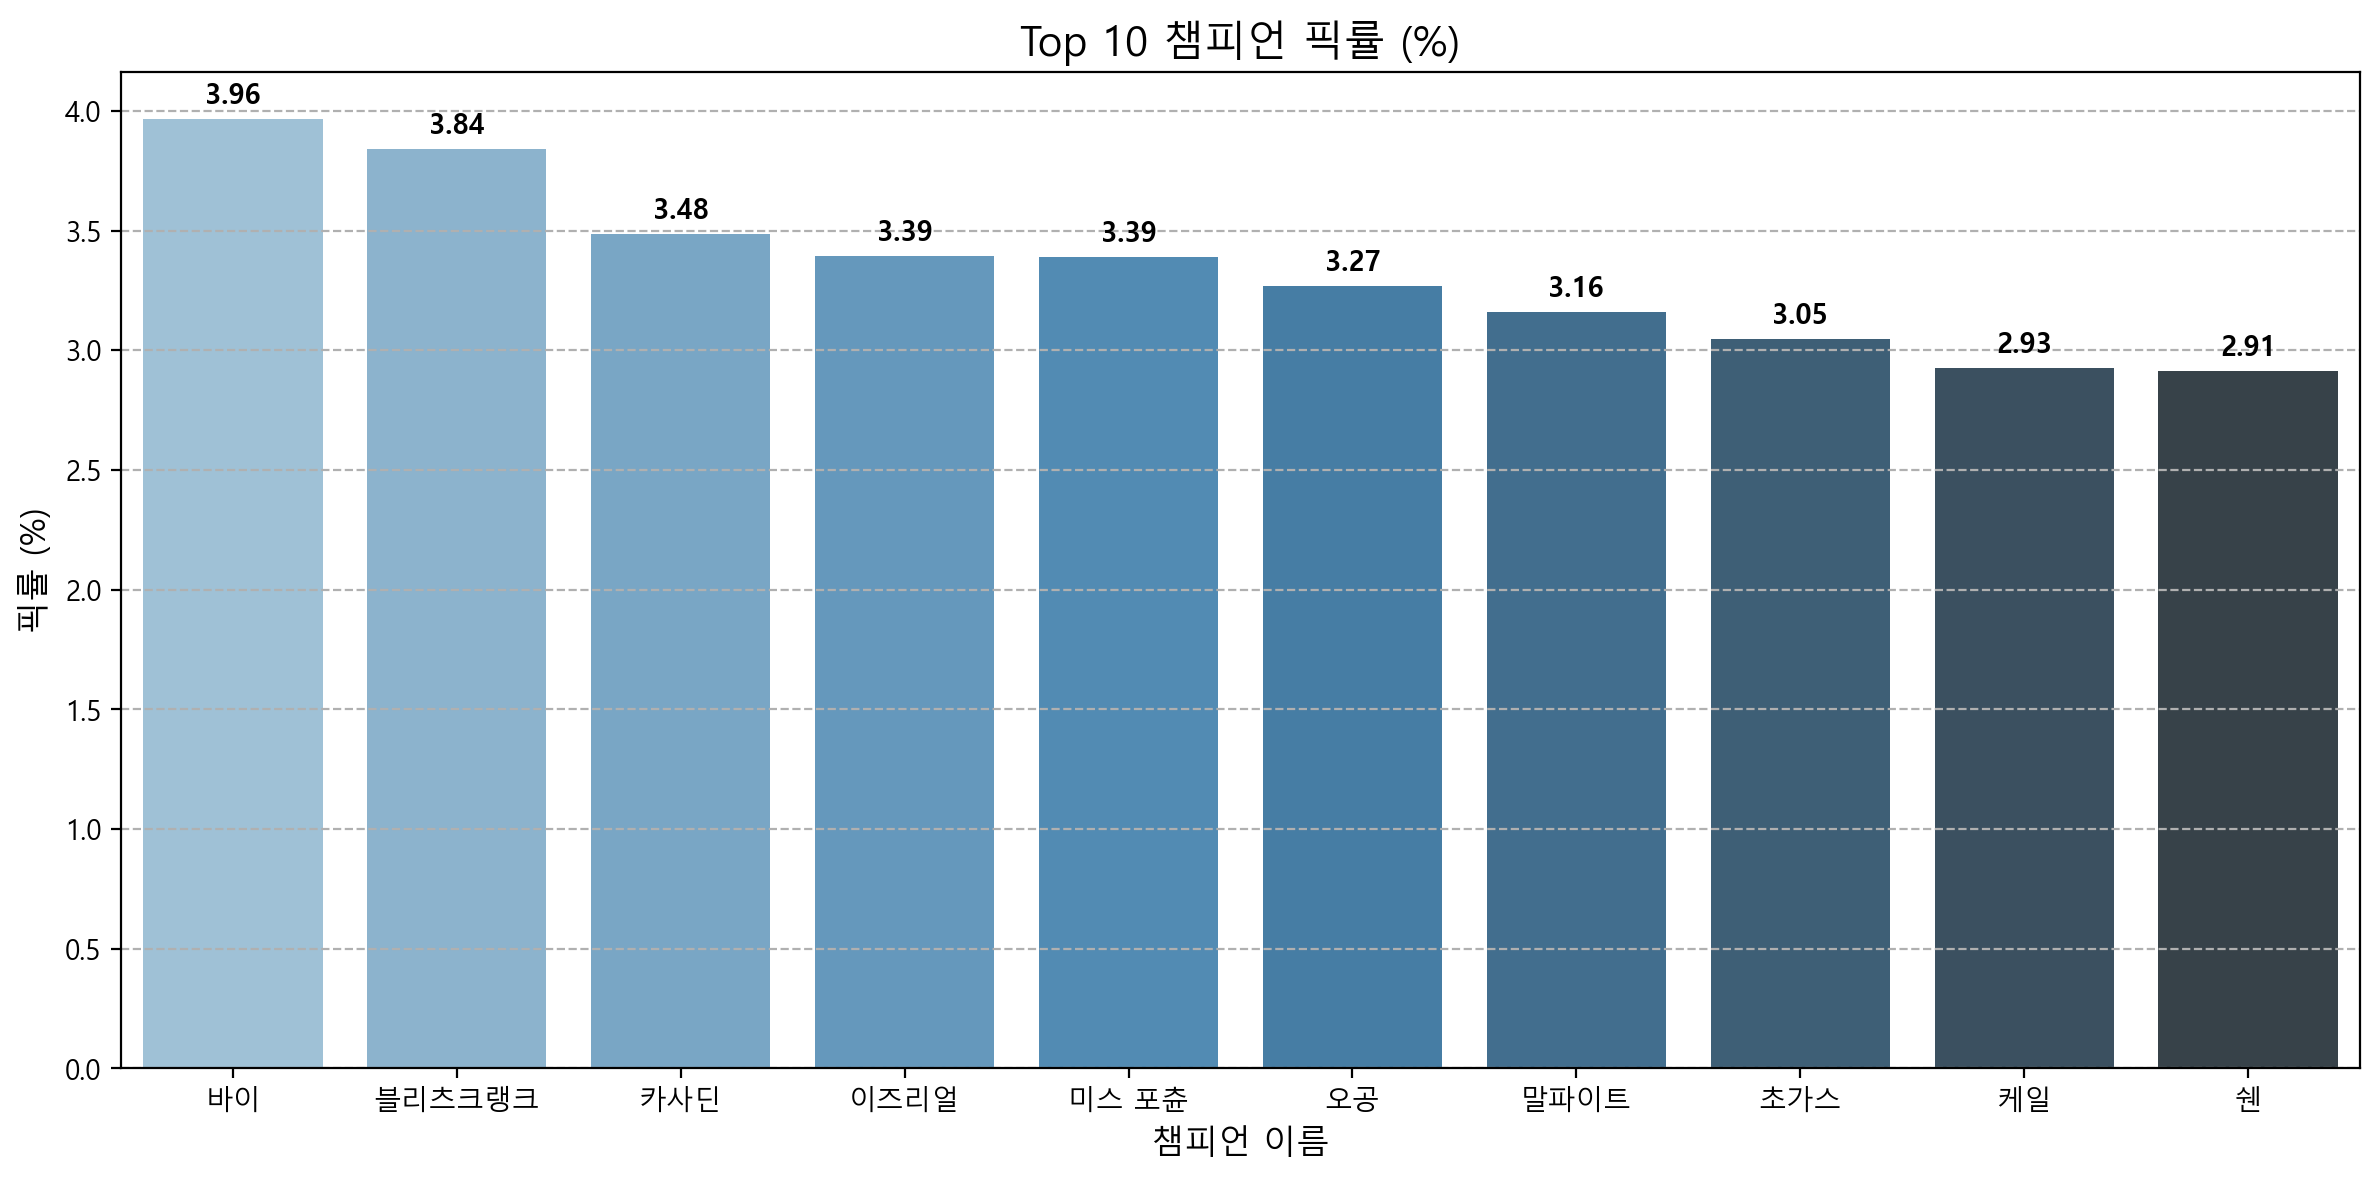

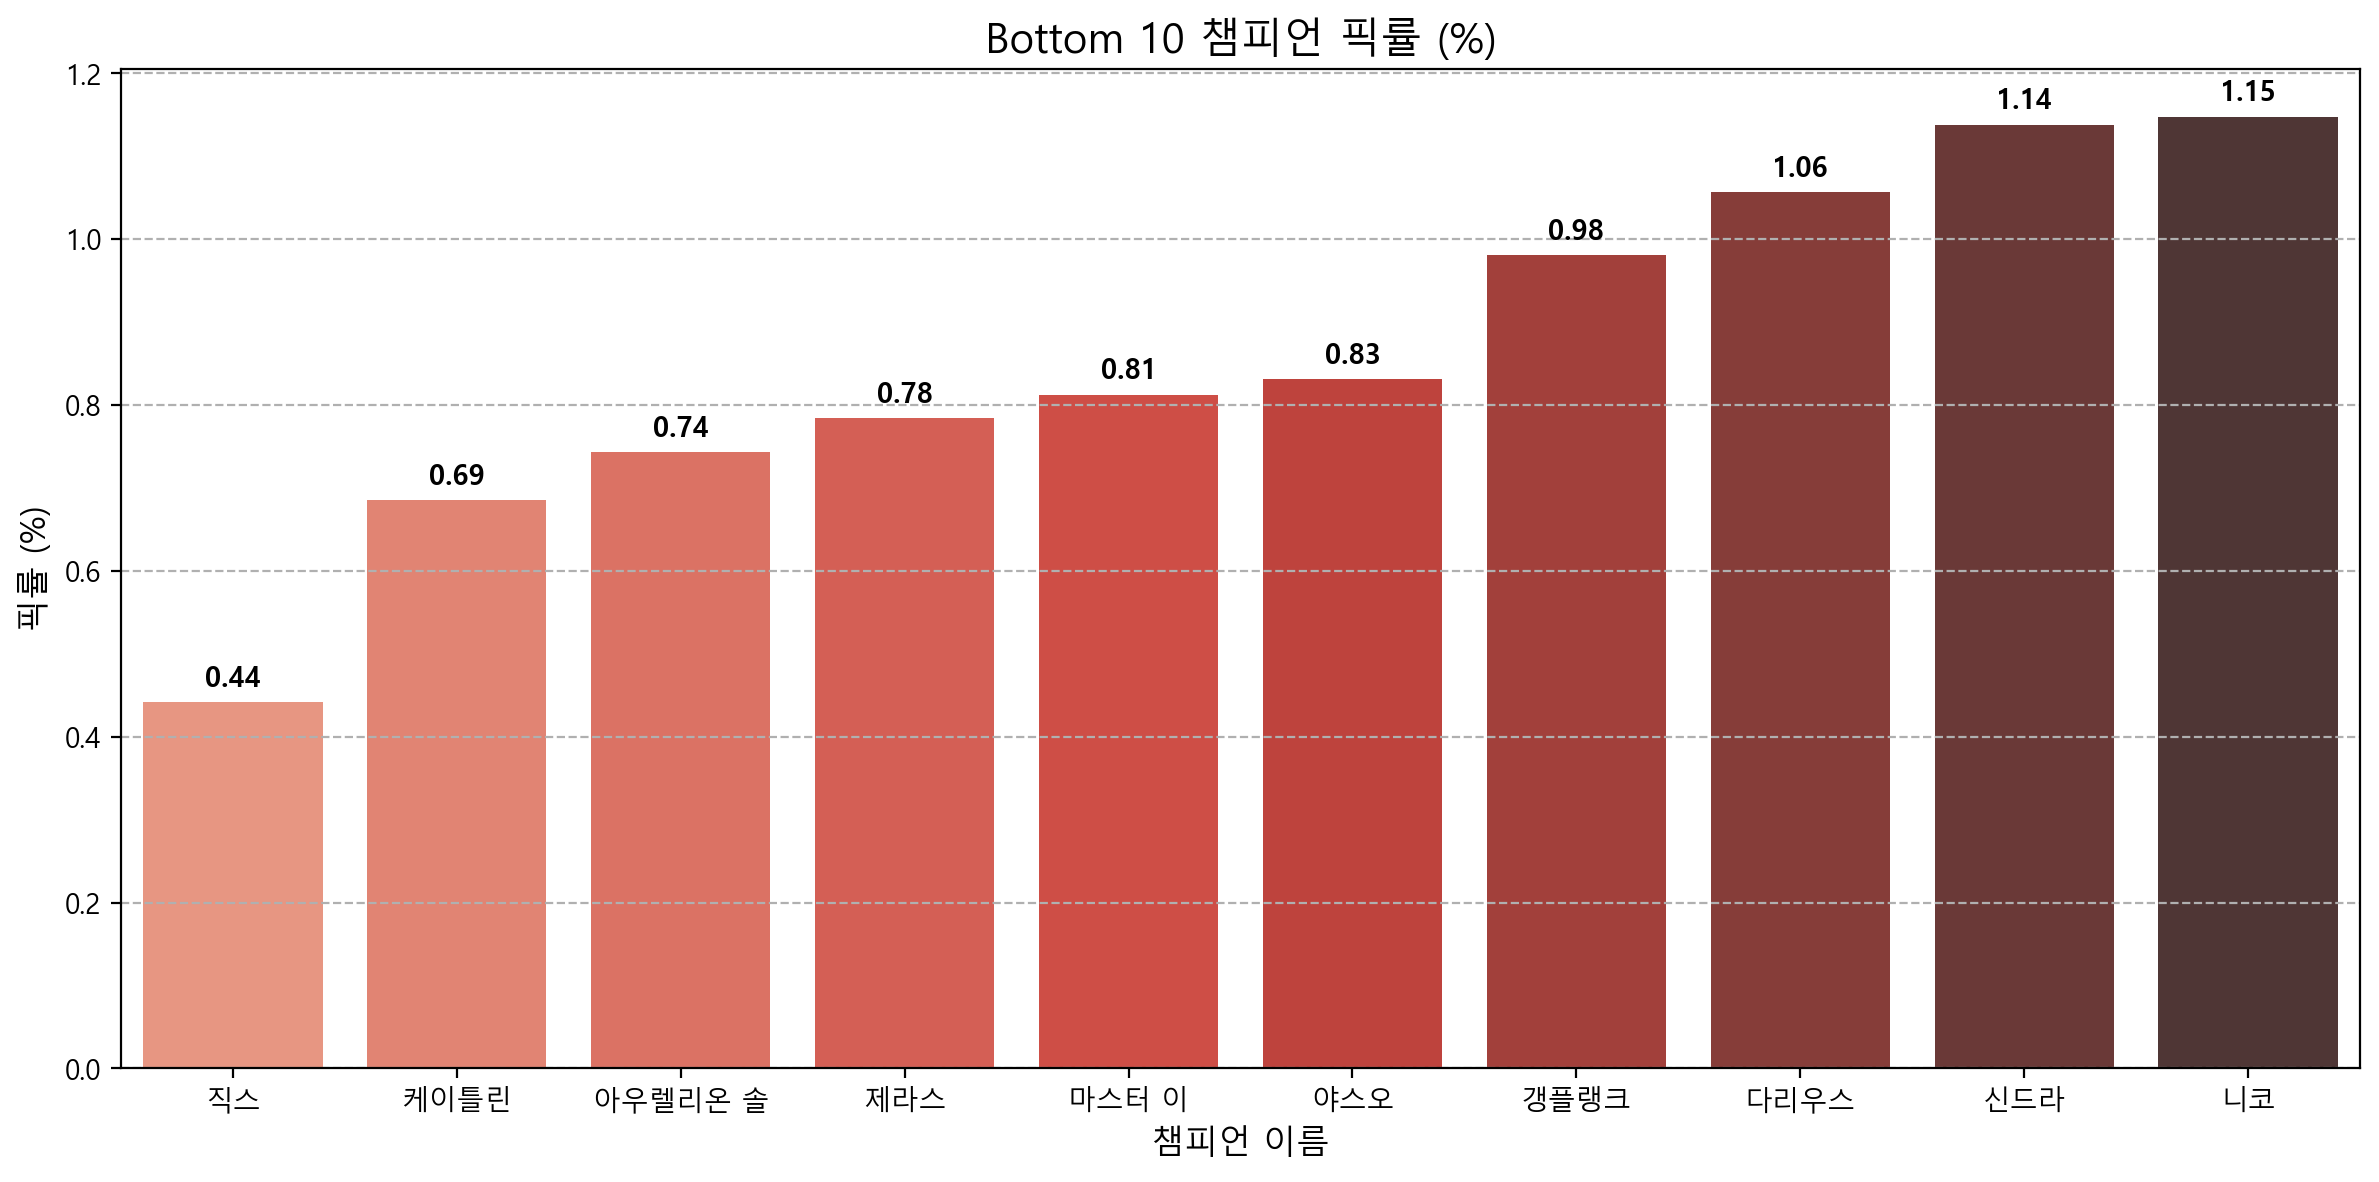

In [101]:
# 데이터 시각화!!!

# 픽률 시각화

plt.figure(figsize=(12, 6))
champ_pickrate = sns.barplot(
    x='ChampionName', 
    y='PickRate', 
    data=top_10_champs.reset_index(), 
    palette='Blues_d'
)
plt.title('Top 10 챔피언 픽률 (%)', fontsize=15)
plt.xlabel('챔피언 이름', fontsize=12)
plt.ylabel('픽률 (%)', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle='--')

# 픽률 값 표시 (소수점 둘째 자리까지)
for container in champ_pickrate.containers:
    champ_pickrate.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
ax_bottom_pickrate = sns.barplot( 
    x='ChampionName', 
    y='PickRate', 
    data=bottom_10_champs.reset_index(), 
    palette='Reds_d'
)
plt.title('Bottom 10 챔피언 픽률 (%)', fontsize=15)
plt.xlabel('챔피언 이름', fontsize=12)
plt.ylabel('픽률 (%)', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle='--')

# 픽률 값 표시 (소수점 둘째 자리까지)
for container in ax_bottom_pickrate.containers:
    ax_bottom_pickrate.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()

In [102]:
# -------------------------------------------------------------------
# 최적화 코드: Explode 기반으로 시너지 데이터 변환 (속도 대폭 개선)
# -------------------------------------------------------------------

# 1. 원본 인덱스(match_id 역할) 및 필요한 컬럼 추출
df_temp = total_df[['combination', 'Ranked', 'top4']].reset_index().rename(columns={'index': 'match_id'})

# 2. 'combination' 딕셔너리를 [(이름, 레벨), ...] 리스트로 변환 (속도 향상)
#    - list(d.items())를 통해 딕셔너리를 튜플 리스트로 변환합니다.
df_temp['combination_items'] = df_temp['combination'].apply(
    lambda d: list(d.items()) if isinstance(d, dict) else [None]
)

# 3. explode를 사용하여 리스트를 행으로 분리 (가장 큰 속도 개선)
df_temp = df_temp.explode('combination_items')

# 4. 분리된 튜플을 다시 두 개의 컬럼으로 나누기
df_combinations = df_temp.assign(
    CombinationName=df_temp['combination_items'].apply(lambda x: x[0] if isinstance(x, tuple) else None),
    CombinationLevel=df_temp['combination_items'].apply(lambda x: x[1] if isinstance(x, tuple) else None)
).dropna(subset=['CombinationName']) # None 값 제거

# 5. 최종 데이터프레임 정리 (필요없는 임시 컬럼 제거)
df_combinations = df_combinations[['match_id', 'CombinationName', 'CombinationLevel', 'Ranked', 'top4']].reset_index(drop=True)

# print(df_combinations.head()) # 검수용

In [103]:
# # -----------------------------------------------------
# # 1. 시너지 데이터 구조 변환 (Explode)
# # -----------------------------------------------------

# # 'combination' 컬럼의 딕셔너리를 분리하고 원본 인덱스를 포함하여 DataFrame 생성
# # apply(pd.Series)는 딕셔너리의 '키'를 컬럼으로 만들고 '값'을 행에 채웁니다.
# # stack()을 사용하여 이 컬럼들을 하나의 '시너지 이름' 컬럼으로 펼칩니다.
# df_combinations = total_df.apply(lambda row: pd.Series(row['combination']), axis=1).stack().reset_index()

# # 컬럼 이름 지정: level_0은 매치 ID, level_1은 시너지 이름, 0은 활성화 레벨
# df_combinations.columns = ['match_id', 'CombinationName', 'CombinationLevel'] 

# # 필요한 매치 정보('Ranked', 'top4')를 인덱스로 매칭하여 다시 병합
# # (시너지가 포함된 매치의 등수 정보를 연결)
# df_combinations = df_combinations.set_index('match_id').join(total_df[['Ranked', 'top4']])
# df_combinations = df_combinations.reset_index(drop=True)

# -----------------------------------------------------
# 2. 시너지별 픽률, 평균 등수 계산
# -----------------------------------------------------

combination_stats = df_combinations.groupby('CombinationName').agg(
    # 픽 횟수 (활성화된 시너지가 등장한 총 횟수)
    PickCount=('CombinationName', 'count'), 
    # 평균 등수 (Ranked 컬럼 사용)
    AvgPlacement=('Ranked', 'mean') 
)

# 픽률 계산
total_picks_comb = combination_stats['PickCount'].sum()
combination_stats['PickRate'] = (combination_stats['PickCount'] / total_picks_comb) * 100

# -----------------------------------------------------
# 3. Top 10 및 Bottom 10 시너지 추출
# -----------------------------------------------------

# Top 10 (픽 횟수 내림차순)
top_10_comb = combination_stats.sort_values(by='PickCount', ascending=False).head(10)

# Bottom 10 (픽 횟수 오름차순)
bottom_10_comb = combination_stats.sort_values(by='PickCount', ascending=True).head(10)

print("Top 10 시너지 픽률 및 평균 등수")
print(top_10_comb[['PickRate', 'AvgPlacement']].round({'PickRate': 2, 'AvgPlacement': 2}).to_string())
print("\n" + "="*45 + "\n")
print("Bottom 10 시너지 픽률 및 평균 등수")
print(bottom_10_comb[['PickRate', 'AvgPlacement']].round({'PickRate': 2, 'AvgPlacement': 2}).to_string())

Top 10 시너지 픽률 및 평균 등수
                 PickRate  AvgPlacement
CombinationName                        
시공간                 11.30          4.23
천상                   7.72          4.26
용병                   7.20          3.94
총잡이                  6.53          4.25
마나 약탈자               6.41          4.16
검사                   5.86          4.41
싸움꾼                  5.70          4.32
마법사                  5.58          4.27
선봉대                  4.55          4.52
저격수                  4.13          4.31


Bottom 10 시너지 픽률 및 평균 등수
                 PickRate  AvgPlacement
CombinationName                        
공허                   1.09          4.24
우주선                  1.31          3.54
우주 해적                2.24          4.53
사이버네틱                2.35          4.45
반군                   2.57          4.05
별 수호자                2.59          4.45
폭파광                  2.59          4.08
암흑의 별                2.72          4.30
메카 파일럿               2.74          4.37
수호자                  3.18      

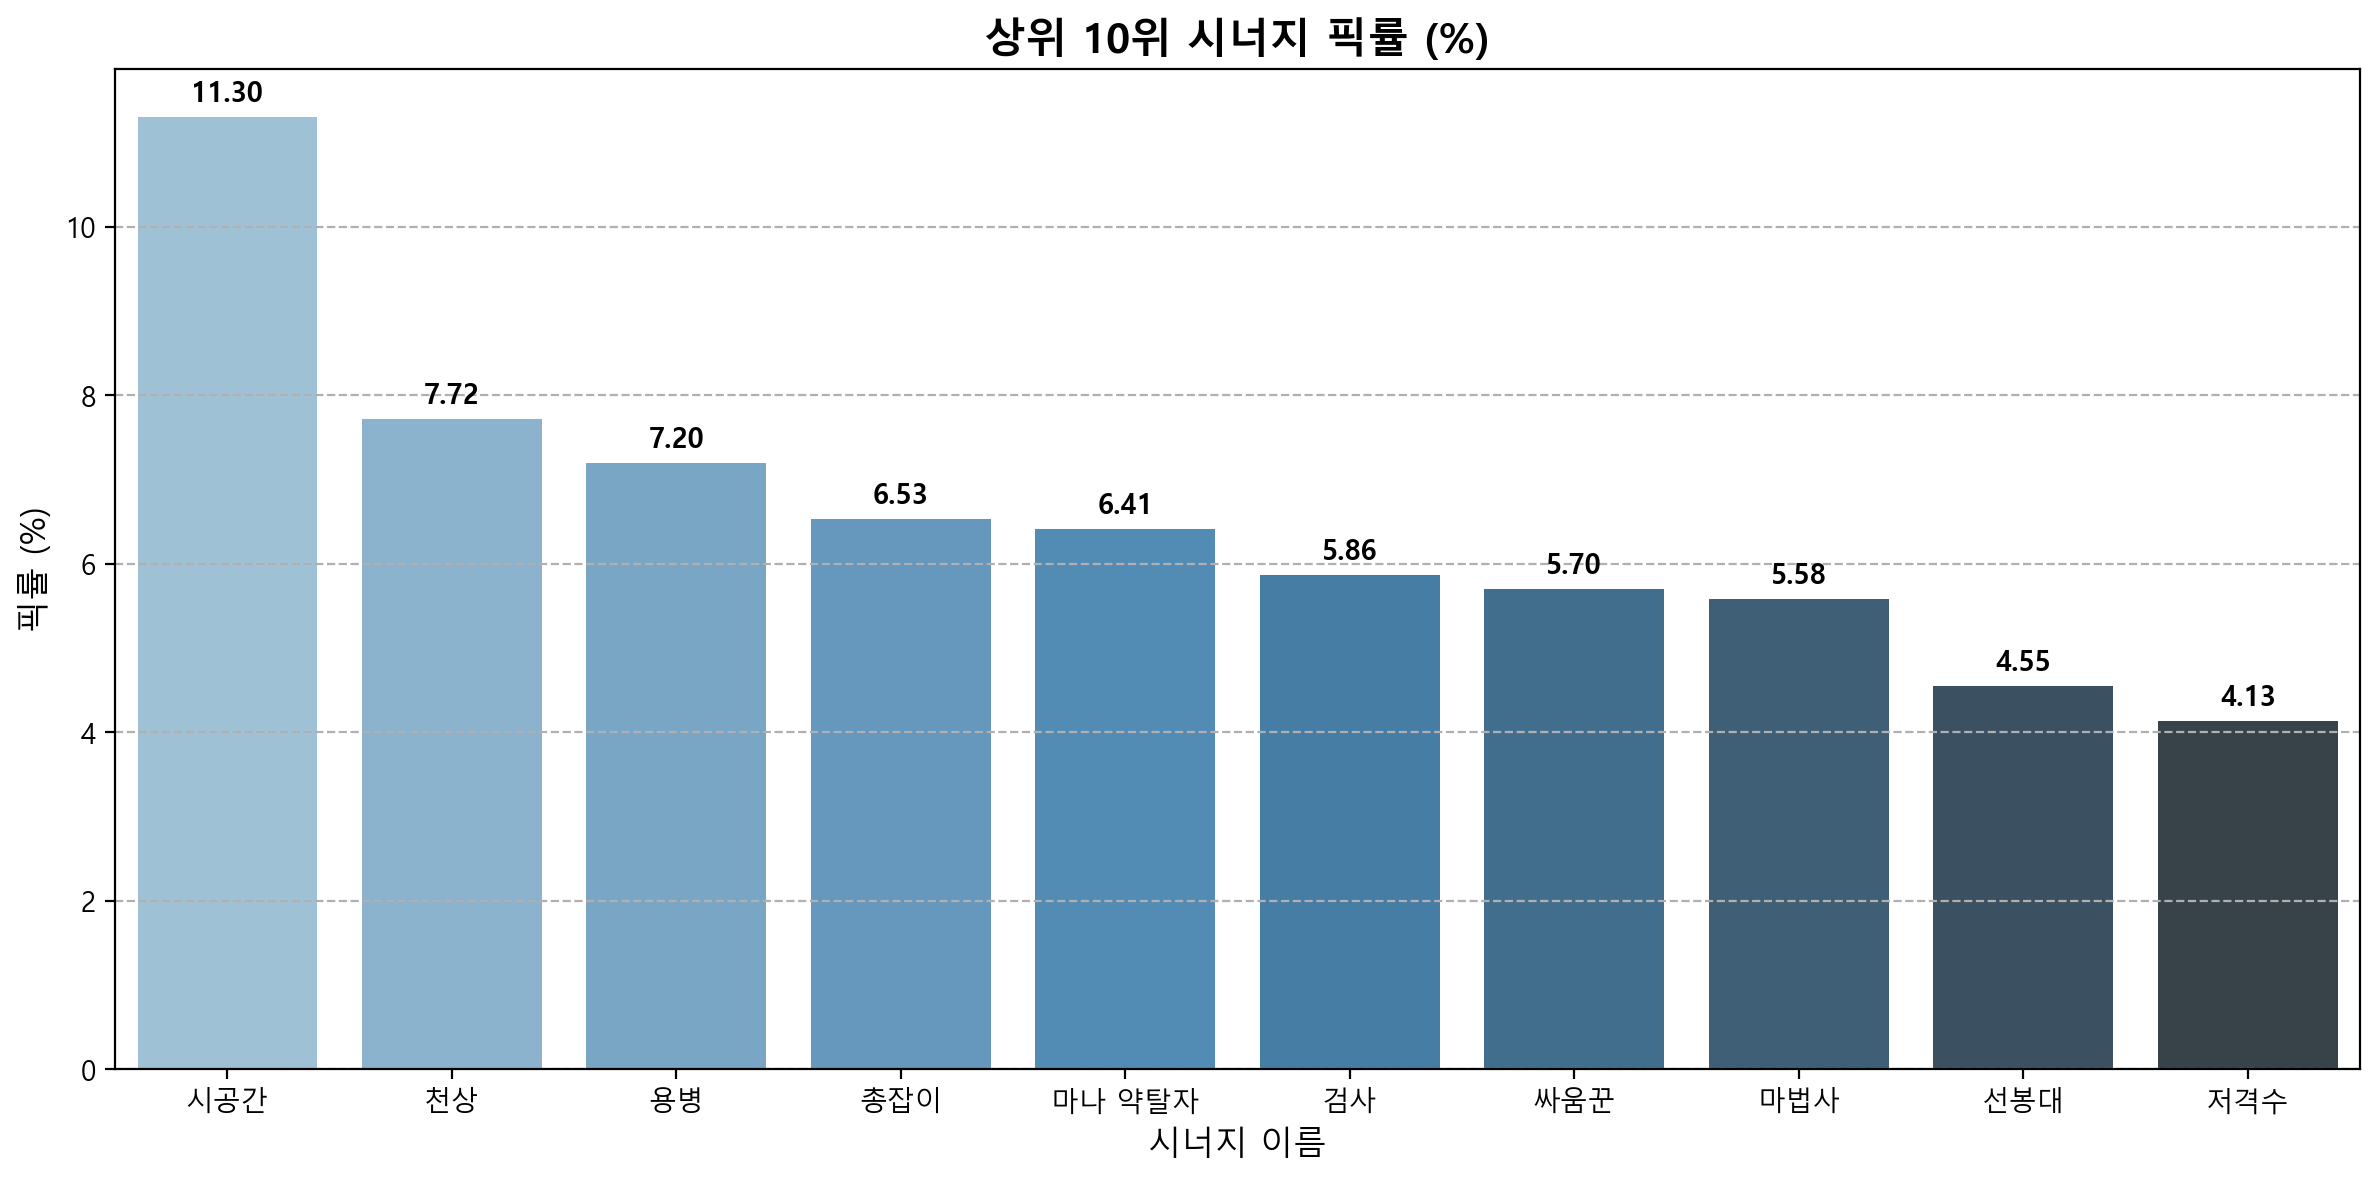

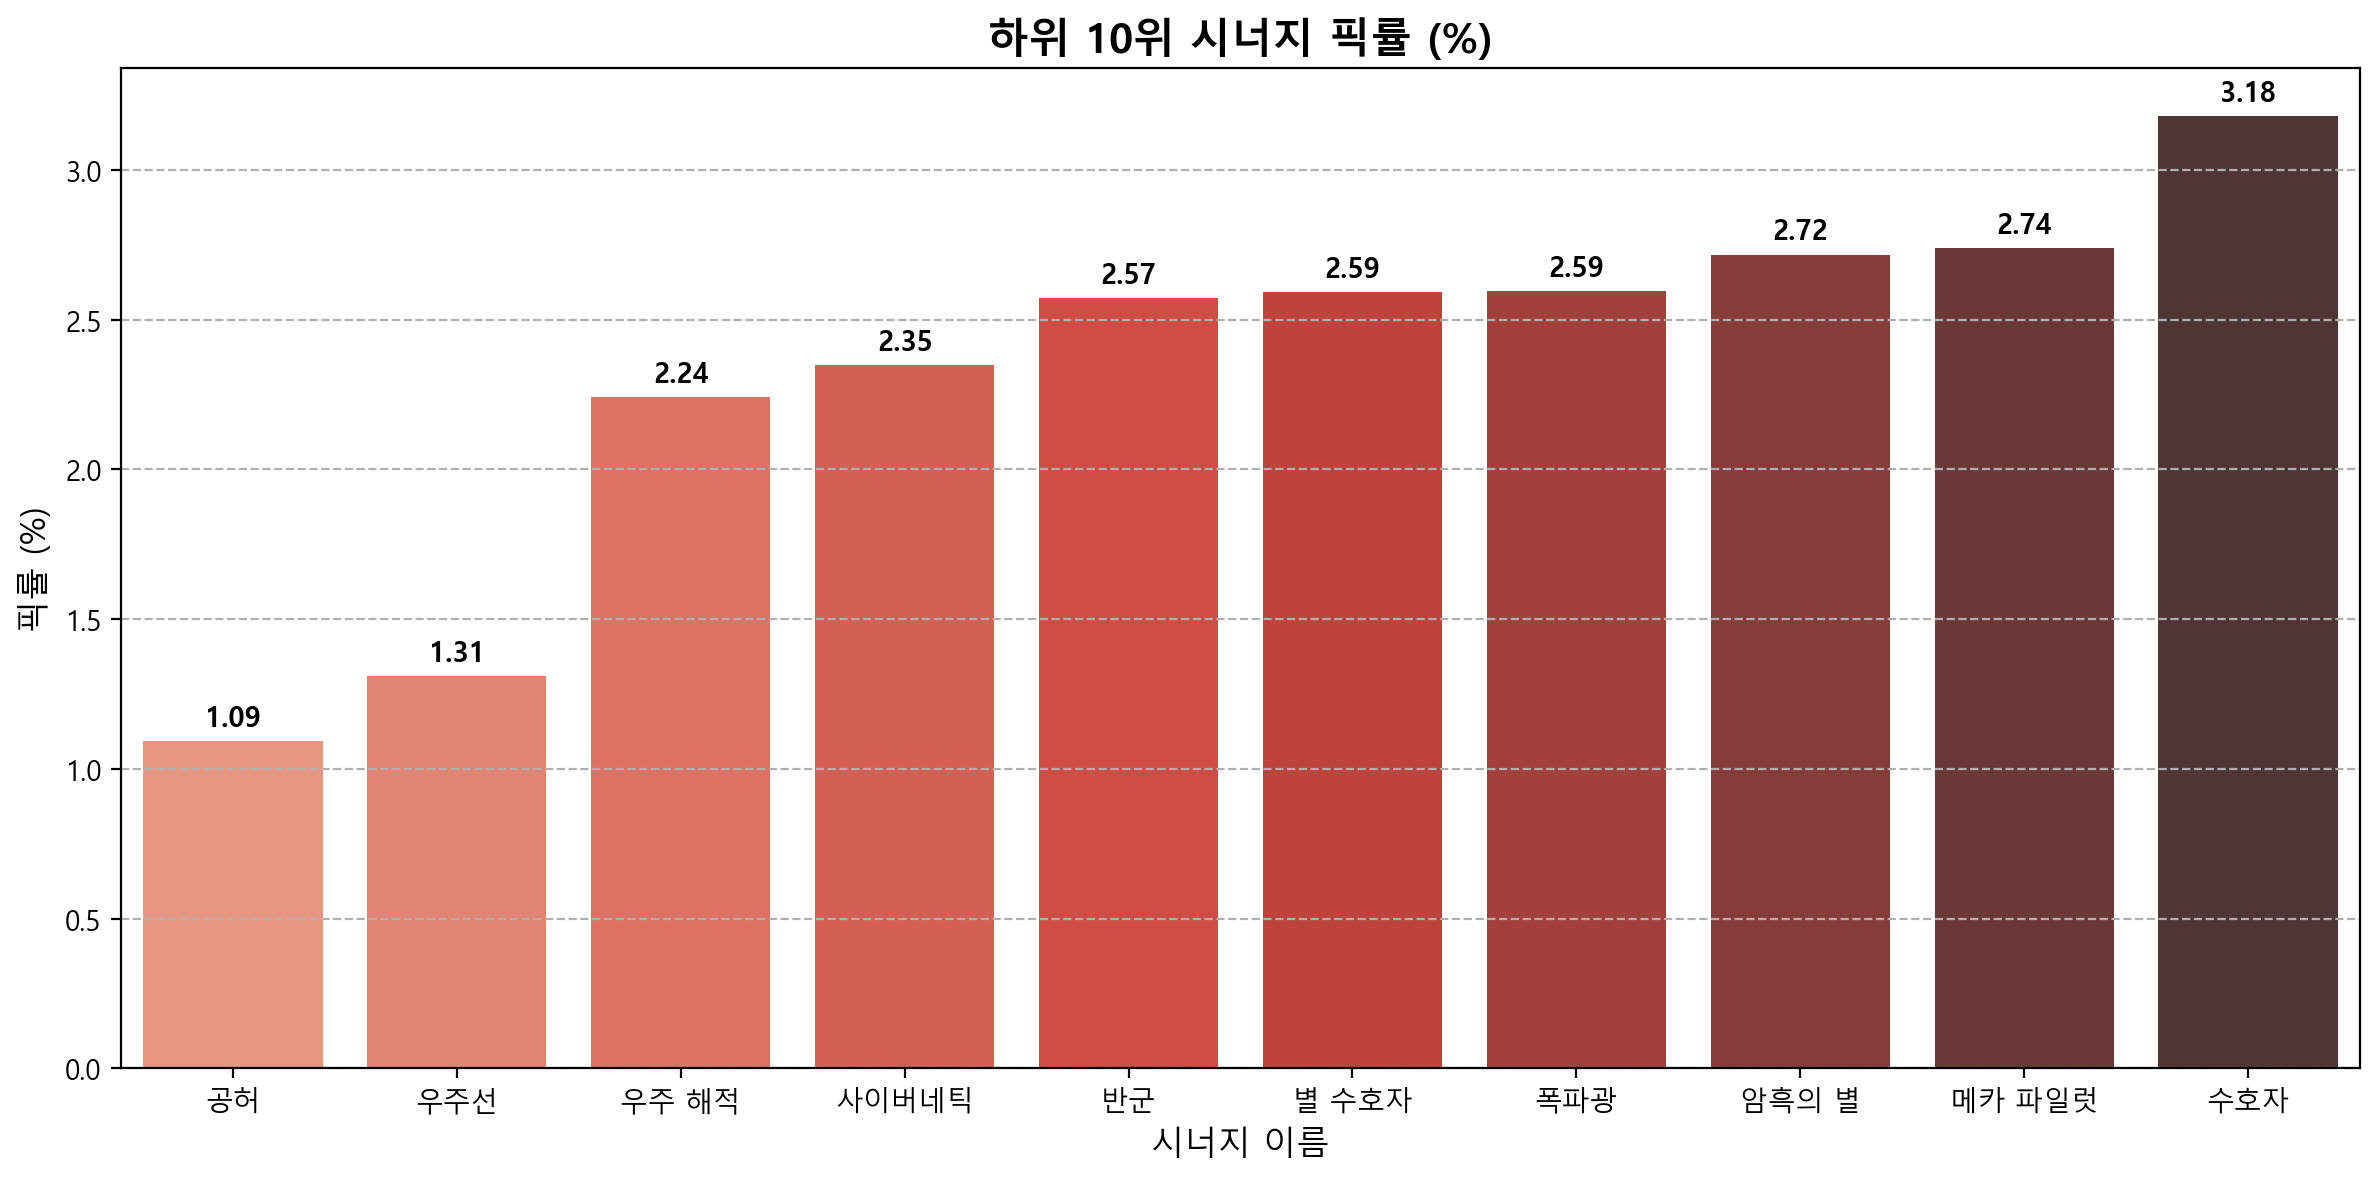

In [104]:
plt.figure(figsize=(12, 6))
top_comb_pickrate = sns.barplot(
    x='CombinationName', 
    y='PickRate', 
    data=top_10_comb.reset_index(), 
    palette='Blues_d'
)
plt.title('상위 10위 시너지 픽률 (%)', fontsize=15, fontweight='bold')
plt.xlabel('시너지 이름', fontsize=12)
plt.ylabel('픽률 (%)', fontsize=12)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--')

# 값 표시 (소수점 둘째 자리까지)
for container in top_comb_pickrate.containers:
    top_comb_pickrate.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
bottom_comb_pickrate = sns.barplot(
    x='CombinationName', 
    y='PickRate', 
    data=bottom_10_comb.reset_index(), 
    palette='Reds_d'
)
plt.title('하위 10위 시너지 픽률 (%)', fontsize=15, fontweight='bold')
plt.xlabel('시너지 이름', fontsize=12)
plt.ylabel('픽률 (%)', fontsize=12)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--')

# 값 표시 (소수점 둘째 자리까지)
for container in bottom_comb_pickrate.containers:
    bottom_comb_pickrate.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()

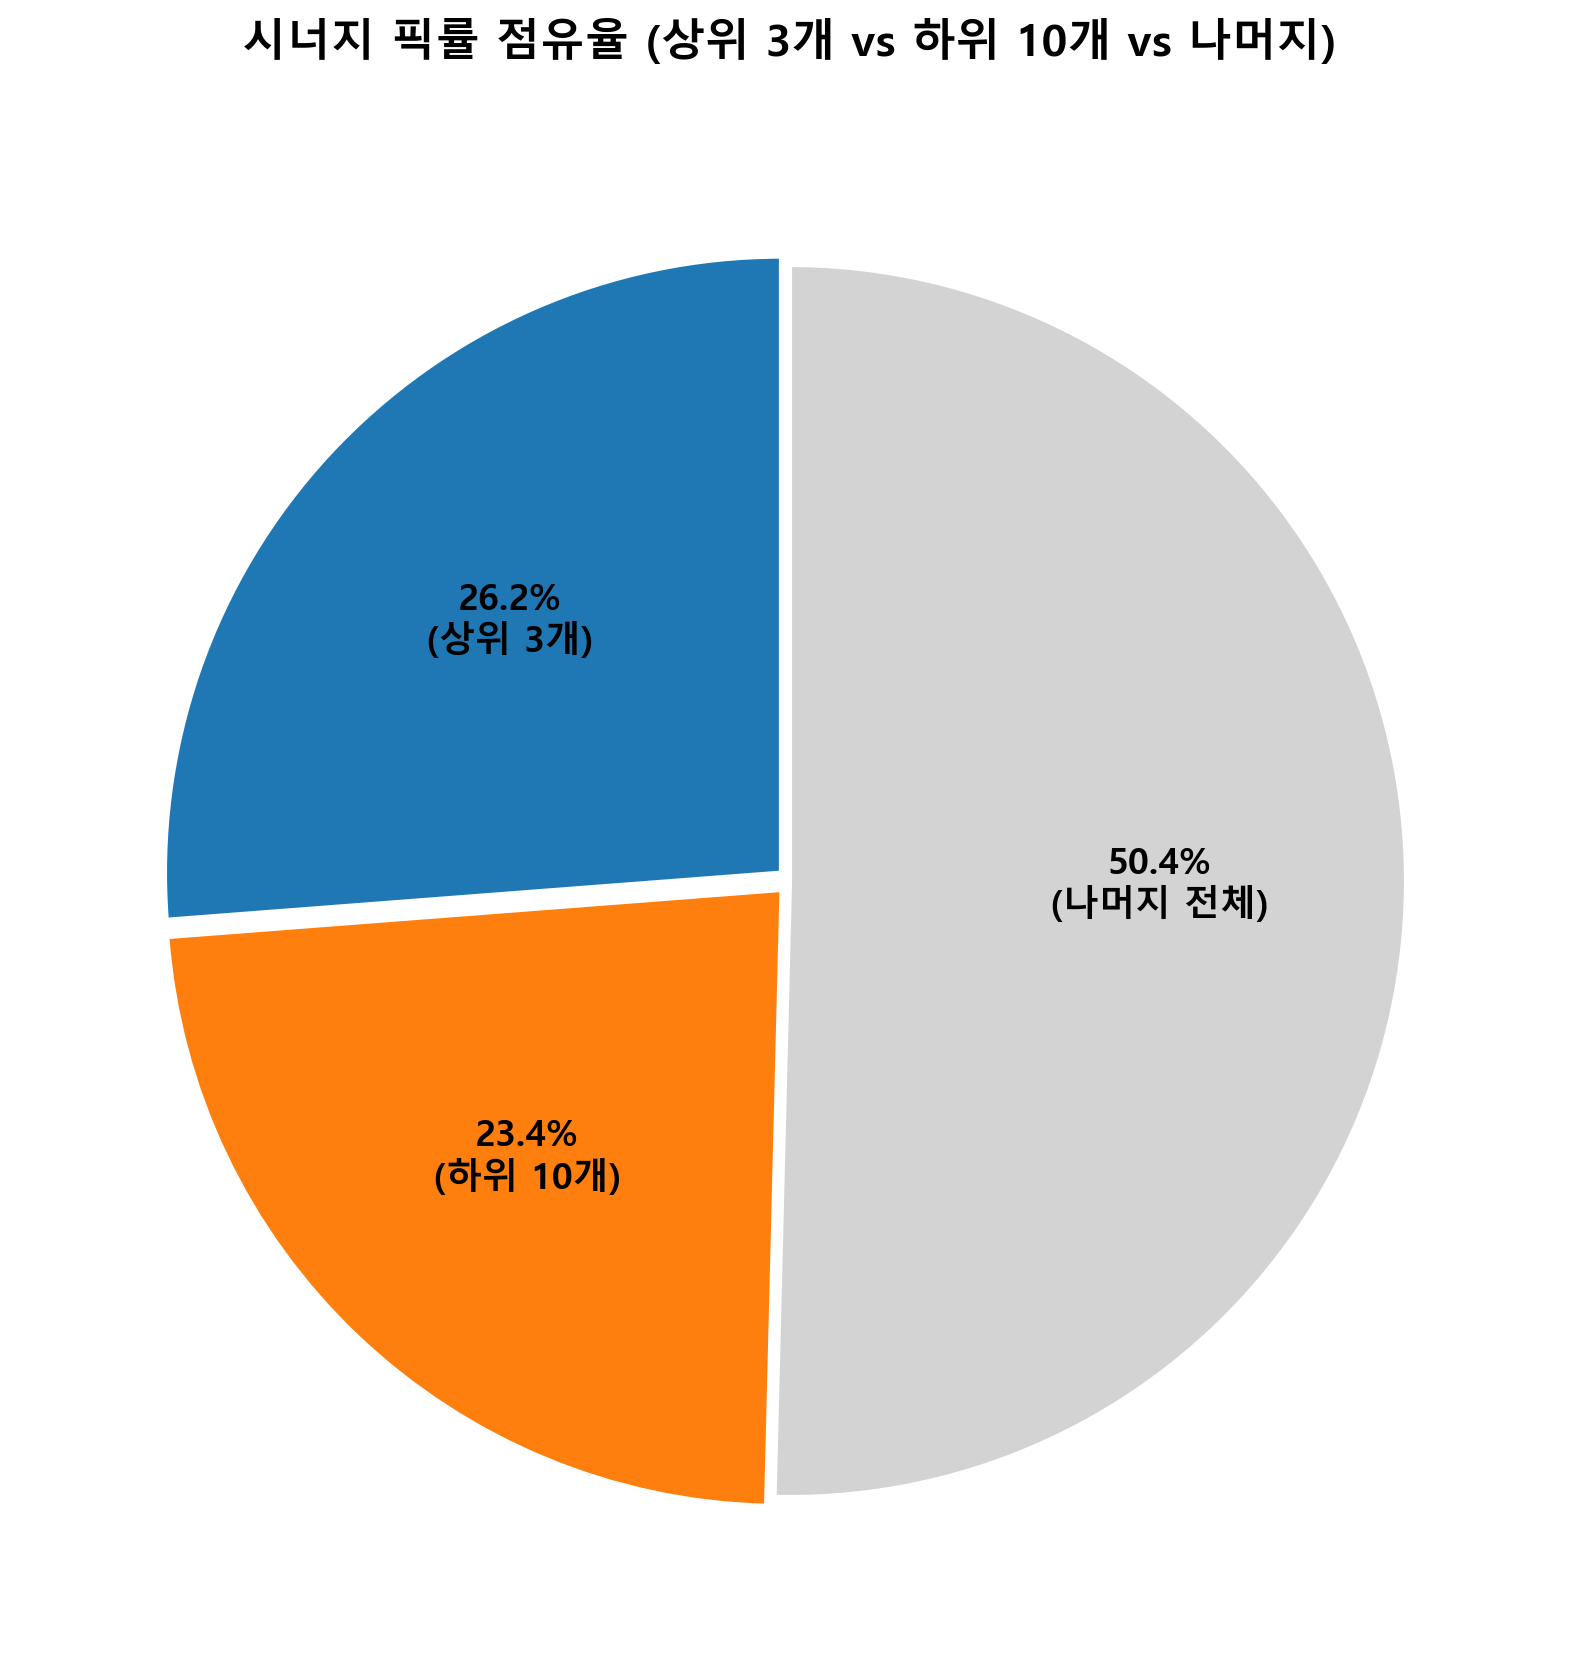

In [105]:
# 'combination_stats'가 정의되어 있다고 가정

# 상위 3개 시너지 추출
top_3_comb = combination_stats.sort_values(by='PickRate', ascending=False).head(3)

# 하위 10개 시너지 추출
bottom_10_comb = combination_stats.sort_values(by='PickRate', ascending=True).head(10)

# 데이터 준비 및 집계
# 상위 3개와 하위 10개의 총 픽률
top_3_rate = top_3_comb['PickRate'].sum()
bottom_10_rate = bottom_10_comb['PickRate'].sum()

# 나머지 전체 시너지의 픽률 계산
remaining_rate = combination_stats['PickRate'].sum() - top_3_rate - bottom_10_rate

# 파이 차트 데이터 생성
pie_data_final = pd.Series([top_3_rate, bottom_10_rate, remaining_rate], 
                           index=['상위 3개', '하위 10개', '나머지 전체'])

# 시각화 (파이 차트)
explode_settings = [0.02, 0.02, 0] # 상위 3개와 하위 10개 조각 분리

# 색상 팔레트 설정
custom_colors = ['#1f77b4', '#ff7f0e', '#D3D3D3'] 

plt.figure(figsize=(10, 10))

# 인덱스 레이블을 pie 내부 텍스트에 포함시키기 위한 커스텀 함수
def autopct_format(pct):
    # 현재 퍼센트 값이 pie_data_final의 몇 번째 인덱스(조각)에 해당하는지 찾습니다.
    total = pie_data_final.sum()
    value = (pct * total) / 100
    
    # 해당 값(value)을 사용하여 인덱스 이름을 찾습니다.
    # pie_data_final.values를 사용하여 인덱스 순서를 기반으로 값을 비교합니다.
    index_name = pie_data_final.index[np.argmin(np.abs(pie_data_final.values - value))]
    
    # 퍼센트와 인덱스 이름을 줄바꿈하여 반환
    return f'{pct:.1f}%\n({index_name})'

# 파이 차트 생성
wedges, texts, autotexts = plt.pie(
    pie_data_final, 
    labels=None, # 레이블을 제거하고 autopct에서 처리합니다
    autopct=autopct_format, # 커스텀 포맷 함수 적용 
    startangle=90, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, 
    colors=custom_colors,
    explode=explode_settings
)

# 텍스트 스타일 조정 (퍼센트와 레이블 텍스트)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')

# 제목 및 기타 설정
plt.title('시너지 픽률 점유율 (상위 3개 vs 하위 10개 vs 나머지)', 
          fontsize=16, 
          fontweight='bold', 
          pad=20)

plt.show()

In [106]:
def calculate_gini(data):
    # 지니 함수를 계산하는 함수
    data = data.sort_values().values
    n = len(data)
    if n == 0:
        return 0
    
    # 누적합을 이용하여 지니계수 계산
    cumulative_sum = data.cumsum()
    # 분모: n * sum(data)
    denominator = n * cumulative_sum[-1] 
    
    # 분자: (2 * i - n - 1) * x_i의 합
    numerator_sum = 0
    for i in range(1, n + 1):
        numerator_sum += (2 * i - n - 1) * data[i - 1]
        
    return numerator_sum / denominator

# 시너지 픽률 데이터로 지니 계수 계산
gini_coefficient = calculate_gini(combination_stats['PickRate'])

print(f"시너지 픽률 지니 계수: {gini_coefficient:.4f}")
# (0.0에 가까우면 균등, 1.0에 가까우면 불균형)

시너지 픽률 지니 계수: 0.2918


In [107]:
# 총 사용된 시너지 수 (df_combinations의 전체 행 수)
total_synergy_activations = len(df_combinations)

# 총 게임 수 (total_df의 행 수 또는 고유 match_id 수)
total_matches = len(total_df) 

# 게임당 평균 시너지 활성화 횟수 계산
avg_synergies_per_match = total_synergy_activations / total_matches

print(f"총 게임 수: {total_matches} 개")
print(f"총 시너지 활성화 횟수: {total_synergy_activations} 회")
print(f"게임당 평균 시너지 활성화 횟수: {avg_synergies_per_match:.2f} 회")

총 게임 수: 390803 개
총 시너지 활성화 횟수: 1763366 회
게임당 평균 시너지 활성화 횟수: 4.51 회


In [108]:
# 가장 많이 사용된 시너지 (Top 1 Combination) 이름 찾기
# combination_stats는 이미 PickCount를 가지고 있으므로, 가장 높은 시너지를 찾습니다.
top_1_comb_name = combination_stats['PickCount'].idxmax()

# Top 1 시너지의 총 활성화 횟수 (총 사용된 횟수)
top_1_total_activations = combination_stats.loc[top_1_comb_name, 'PickCount']

# 총 게임 수 계산
total_matches = len(total_df) 

# 게임당 평균 활성화 횟수 계산
avg_activations_per_match = top_1_total_activations / total_matches

print(f"가장 많이 사용된 시너지: {top_1_comb_name}")
print(f"해당 시너지 총 활성화 횟수: {top_1_total_activations} 회")
print(f"총 게임 수: {total_matches} 개")
print(f"{top_1_comb_name} 시너지의 게임당 평균 활성화 횟수: {avg_activations_per_match:.4f} 회")

가장 많이 사용된 시너지: 시공간
해당 시너지 총 활성화 횟수: 199319 회
총 게임 수: 390803 개
시공간 시너지의 게임당 평균 활성화 횟수: 0.5100 회


In [109]:
# 가장 많이 사용된 시너지 (Top 1 Combination) 이름과 총 활성화 횟수 찾기
top_1_comb_name = combination_stats['PickCount'].idxmax()
top_1_total_activations = combination_stats.loc[top_1_comb_name, 'PickCount']

# 총 게임 수 계산 (중복 gameId 제거)
# 이전 단계에서 total_df의 인덱스를 매치 식별자로 사용했으므로, 
# 여기서는 total_df의 고유한 인덱스(match_id) 개수를 셉니다.
# 만약 total_df에 'gameId' 또는 'match_id'라는 컬럼이 따로 있다면 그 컬럼의 .nunique()를 사용해야 합니다.
# 여기서는 가장 안전하게 total_df의 인덱스(match_id) 중복을 제거합니다.

# total_df의 인덱스 중 고유한 값의 개수를 셉니다.
# (각 매치별로 8개의 행이 있으므로, .nunique()를 통해 실제 매치 수를 카운트합니다.)
if total_df.index.has_duplicates:
    # 인덱스에 중복이 있다면 고유한 값만 셉니다.
    total_matches = total_df.index.nunique()
else:
    # 인덱스에 중복이 없다면 행의 개수를 8로 나눕니다. (데이터 구조상 8행당 1매치 가정)
    total_matches = len(total_df) // 8

# 만약 total_df에 'match_id'라는 컬럼이 있다면 아래 코드가 가장 정확합니다.
# total_matches = total_df['match_id'].nunique()

# 게임당 평균 활성화 횟수 계산
avg_activations_per_match = top_1_total_activations / total_matches

print(f"가장 많이 사용된 시너지: {top_1_comb_name}")
print(f"해당 시너지 총 활성화 횟수: {top_1_total_activations} 회")
print(f"중복 제거 후 총 게임 수: {total_matches} 개")
print(f"{top_1_comb_name} 시너지의 게임당 평균 활성화 횟수: {avg_activations_per_match:.4f} 회")

가장 많이 사용된 시너지: 시공간
해당 시너지 총 활성화 횟수: 199319 회
중복 제거 후 총 게임 수: 48850 개
시공간 시너지의 게임당 평균 활성화 횟수: 4.0802 회


In [110]:
# total_df의 인덱스 중 고유한 값의 개수를 셉니다.
# (각 매치별로 8개의 행이 있으므로, .nunique()를 통해 실제 매치 수를 카운트합니다.)
if total_df.index.has_duplicates:
    total_matches = total_df.index.nunique()
else:
    # 안전 장치: 인덱스가 고유하다면 8로 나누어 매치 수를 추정
    total_matches = len(total_df) // 8

# total_matches가 0이면 계산 불가능
if total_matches == 0:
    print("오류: 총 게임 수가 0입니다. total_df의 매치 식별자 확인이 필요합니다.")
    # 다음 분석을 위해 임시로 1로 설정
    total_matches = 1 

# 시너지별 총 활성화 횟수를 total_matches로 나누어 '게임당 평균 활성화 횟수' 계산
combination_stats['AvgActivationsPerGame'] = (
    combination_stats['PickCount'] / total_matches
)

# 게임당 평균 활성화 횟수를 기준으로 상위 10개 추출
top_10_avg_activations = combination_stats.sort_values(
    by='AvgActivationsPerGame', ascending=False
).head(10).reset_index()

# 결과 출력 (고객님 요청 형식)
print("Top 10 시너지: 게임당 평균 활성화 횟수 🔥")
print(f"총 게임 수 (중복 제거): {total_matches} 개")
print("=" * 50)

for index, row in top_10_avg_activations.iterrows():
    print(f"{row['CombinationName']} 시너지의 게임당 평균 활성화 횟수: {row['AvgActivationsPerGame']:.4f} 회")

Top 10 시너지: 게임당 평균 활성화 횟수 🔥
총 게임 수 (중복 제거): 48850 개
시공간 시너지의 게임당 평균 활성화 횟수: 4.0802 회
천상 시너지의 게임당 평균 활성화 횟수: 2.7863 회
용병 시너지의 게임당 평균 활성화 횟수: 2.5978 회
총잡이 시너지의 게임당 평균 활성화 횟수: 2.3557 회
마나 약탈자 시너지의 게임당 평균 활성화 횟수: 2.3141 회
검사 시너지의 게임당 평균 활성화 횟수: 2.1167 회
싸움꾼 시너지의 게임당 평균 활성화 횟수: 2.0585 회
마법사 시너지의 게임당 평균 활성화 횟수: 2.0134 회
선봉대 시너지의 게임당 평균 활성화 횟수: 1.6417 회
저격수 시너지의 게임당 평균 활성화 횟수: 1.4910 회


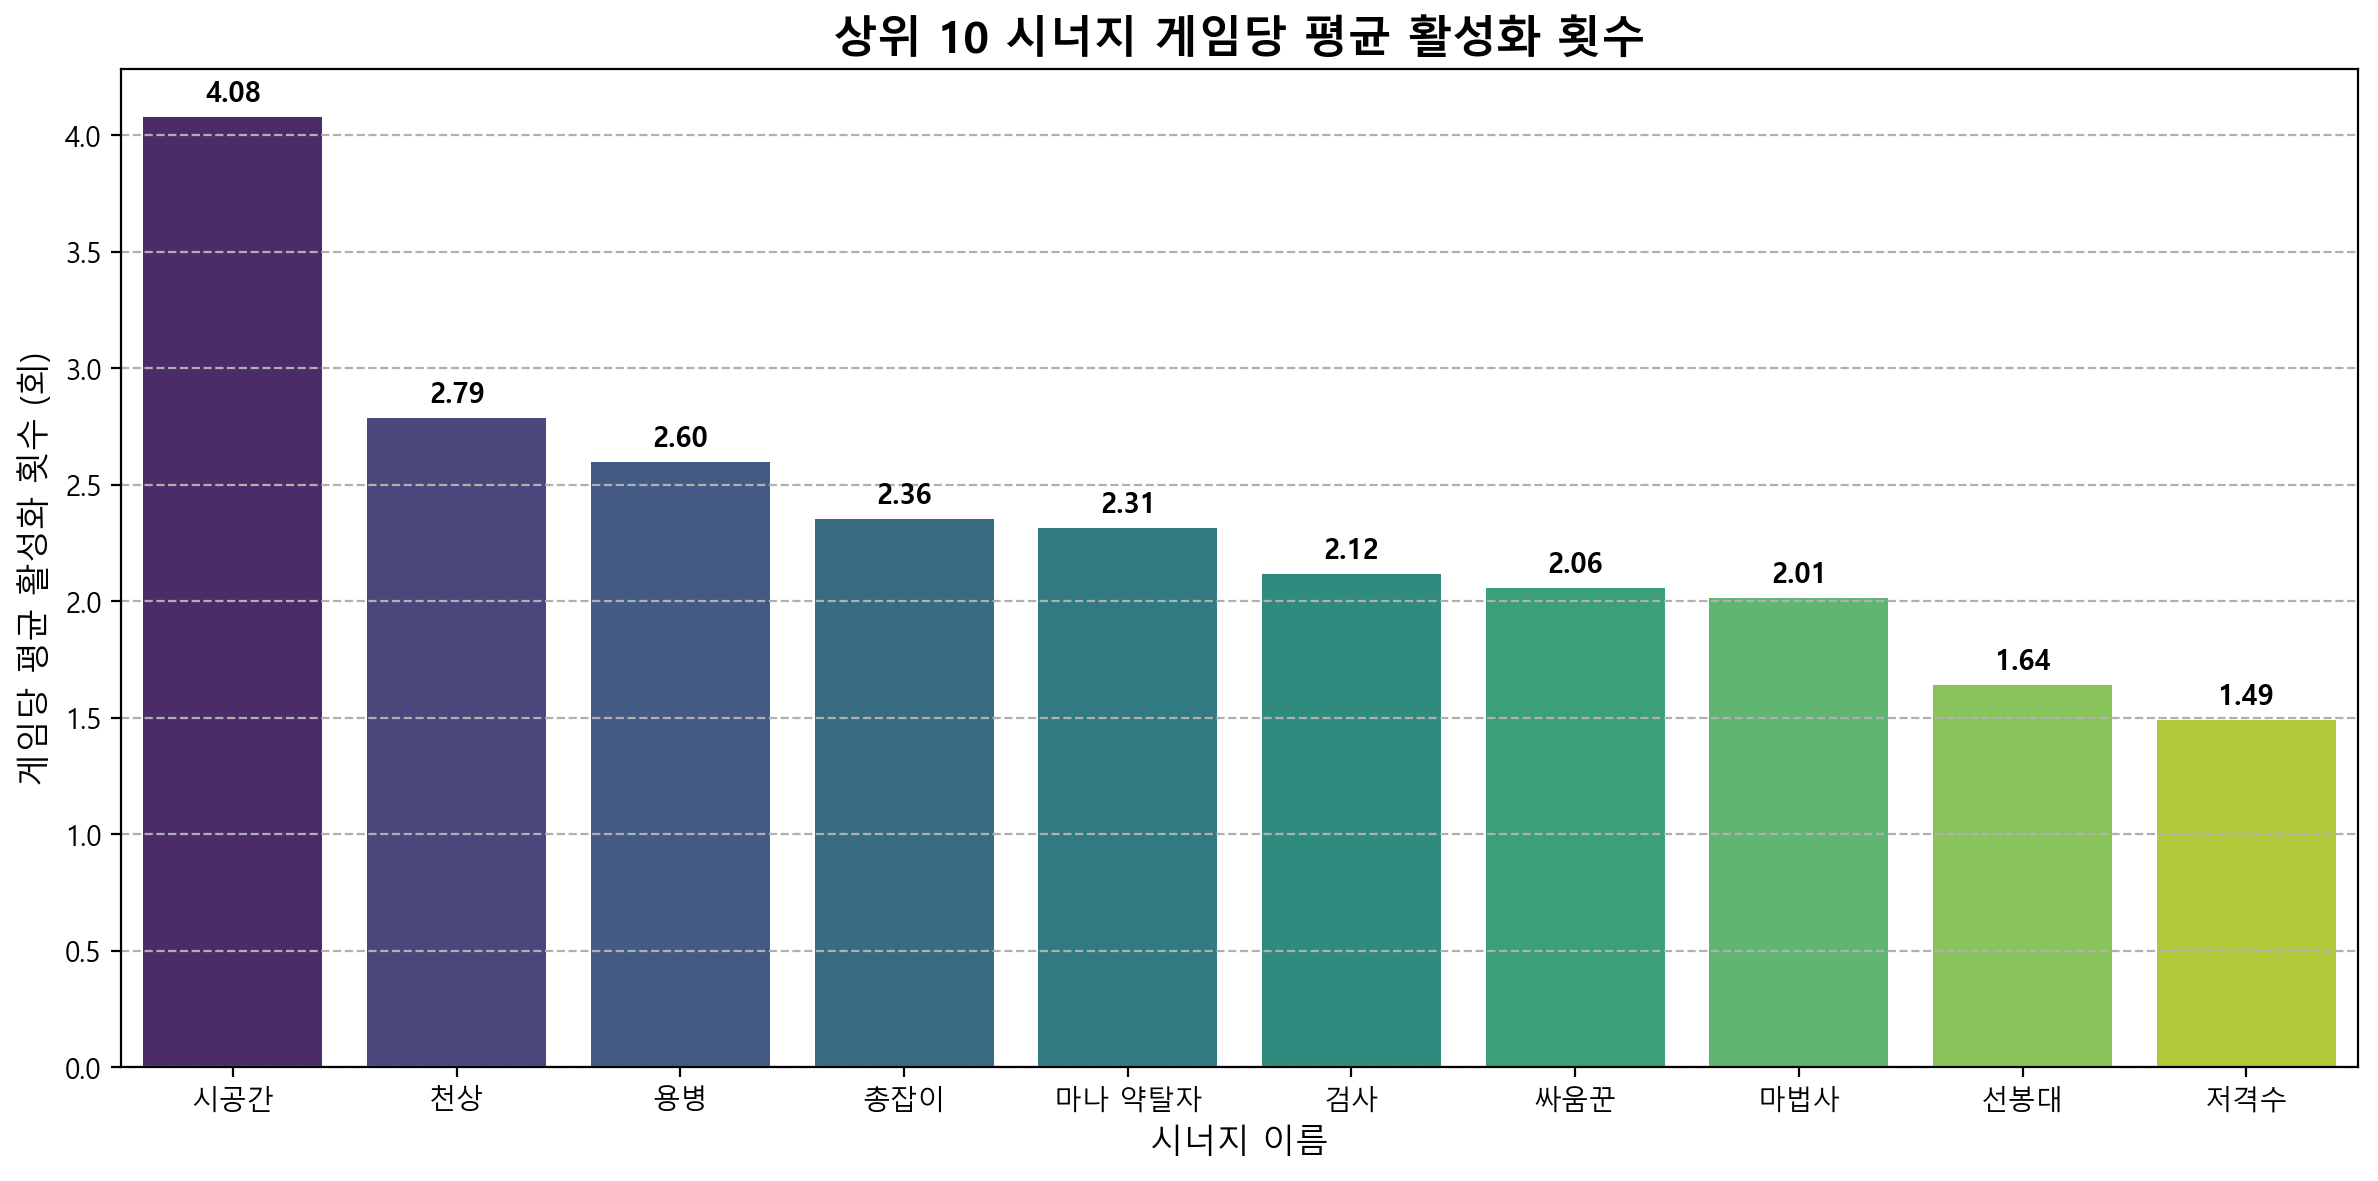

4.08회는 한 게임에서 평균적으로 약 4명의 플레이어가 이 시너지를 사용했음을 의미


In [111]:
plt.figure(figsize=(12, 6))
ax_avg_activations = sns.barplot(
    x='CombinationName', 
    y='AvgActivationsPerGame', 
    data=top_10_avg_activations, 
    palette='viridis' # 높은 빈도를 나타내는 연속형 팔레트 사용
)
plt.title('상위 10 시너지 게임당 평균 활성화 횟수', fontsize=16, fontweight='bold')
plt.xlabel('시너지 이름', fontsize=12)
plt.ylabel('게임당 평균 활성화 횟수 (회)', fontsize=12)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--')

# 값 표시 (소수점 둘째 자리까지)
for container in ax_avg_activations.containers:
    ax_avg_activations.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()

print(f"4.08회는 한 게임에서 평균적으로 약 4명의 플레이어가 이 시너지를 사용했음을 의미")

In [112]:
# 매치별 시너지 개수 계산
synergy_count_per_match = total_df.copy()
synergy_count_per_match['ActiveSynergyCount'] = synergy_count_per_match['combination'].apply(len)


ActiveSynergyCount 데이터 통계:
count    390803.000000
mean          4.512161
std           1.375005
min           0.000000
25%           4.000000
50%           4.000000
75%           5.000000
max          10.000000
Name: ActiveSynergyCount, dtype: float64
------------------------------


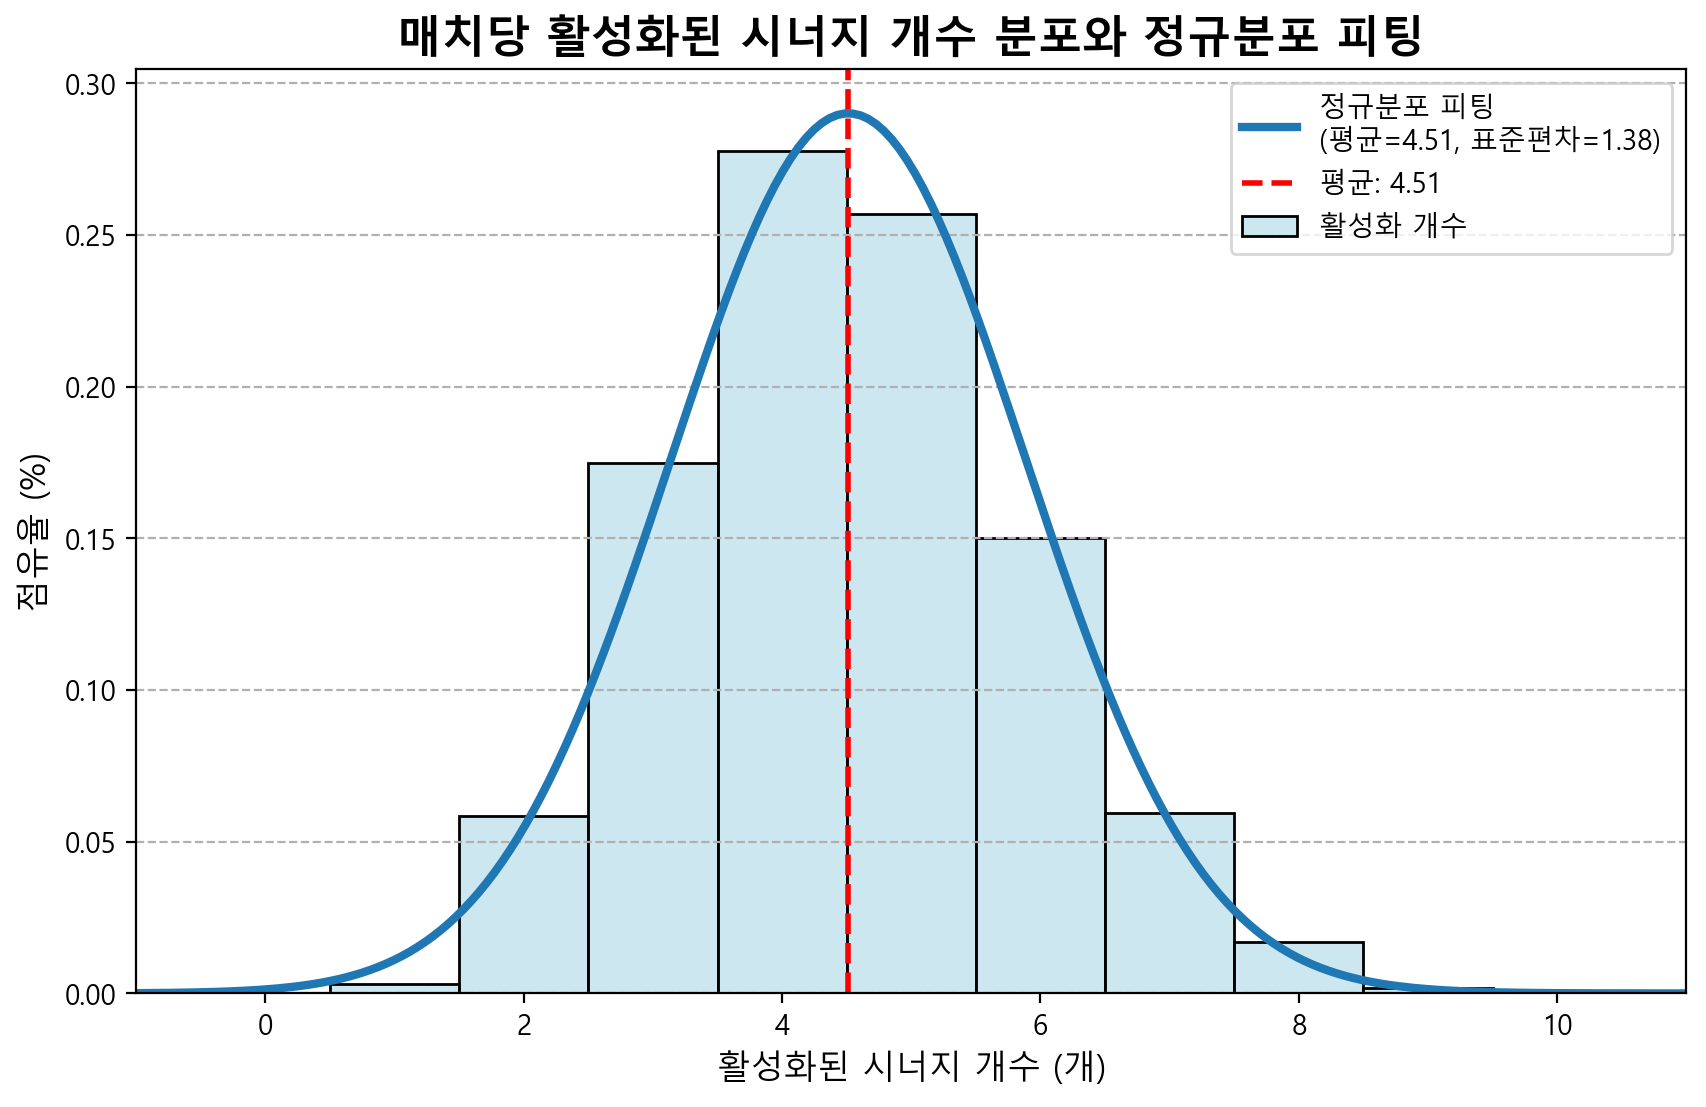

데이터 범위: 최소 0, 최대 10


In [113]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

data_for_fit = synergy_count_per_match['ActiveSynergyCount']

# 데이터 통계치 출력 (범위 및 중심 확인)
print("ActiveSynergyCount 데이터 통계:")
print(data_for_fit.describe())
print("-" * 30)

# 데이터의 평균(mu)과 표준편차(sigma) 계산
mu, sigma = np.mean(data_for_fit), np.std(data_for_fit)

# 정규분포 곡선을 그리기 위한 x, y 값 생성
# 그래프 범위를 데이터의 실제 Min/Max보다 조금 더 넓게 설정하여 곡선이 끊기지 않도록 합니다.
data_min = data_for_fit.min()
data_max = data_for_fit.max()

# x축 범위를 데이터의 Min과 Max를 포함하도록 조정
x_fit = np.linspace(data_min - 1, data_max + 1, 200) 
y_fit = norm.pdf(x_fit, mu, sigma) 

# 시각화 재실행 (bins를 정수 위치에 명확히 설정)
plt.figure(figsize=(10, 6))

# 히스토그램: bins 설정을 정수 중앙에 오도록 다시 확인
bins_array = np.arange(data_min, data_max + 2) - 0.5

sns.histplot(
    data_for_fit, 
    bins=bins_array, # bins 설정을 다시 확인
    stat='density', 
    kde=False, 
    alpha=0.6, 
    color='#ADD8E6', 
    edgecolor='black',
    label='활성화 개수'
)

# 이론적인 정규분포 곡선 추가
plt.plot(x_fit, y_fit, color='#1F78B4', linewidth=3, label=f'정규분포 피팅\n(평균={mu:.2f}, 표준편차={sigma:.2f})') 

plt.axvline(mu, color='red', linestyle='--', linewidth=2, label=f'평균: {mu:.2f}')

plt.title('매치당 활성화된 시너지 개수 분포와 정규분포 피팅', fontsize=16, fontweight='bold')
plt.xlabel('활성화된 시너지 개수 (개)', fontsize=12)
plt.ylabel('점유율 (%)', fontsize=12) 
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.xlim(data_min - 1, data_max + 1) # x축 범위 고정
plt.show()

# 최종 데이터 범위 확인
print(f"데이터 범위: 최소 {data_min}, 최대 {data_max}")

In [114]:
# total_df의 index가 match_id 역할을 한다고 가정합니다.
# 'Tier' 컬럼은 이미 df1-df5 병합 과정에서 포함되었다고 가정합니다.

# 1. df_combinations에 티어(Tier) 정보 병합
# total_df에서 match_id와 Tier 컬럼만 추출하여 병합 준비
tier_info = total_df.reset_index()[['index', 'Tier']].rename(columns={'index': 'match_id'})

# df_combinations에 Tier 정보 추가
# df_combinations는 이전 전처리 단계에서 유효한 시너지 기록만 포함하고 있어야 합니다.
df_tier_comb = df_combinations.merge(tier_info, on='match_id', how='left')

# 2. 티어별, 시너지별 통계 계산
synergy_tier_data = df_tier_comb.groupby(['Tier', 'CombinationName']).agg(
    AvgPlacement=('Ranked', 'mean'), # 평균 등수
    AvgUsageCount=('CombinationName', 'count') # 시너지 총 활성화 횟수 (경쟁 지표)
).reset_index()

print(synergy_tier_data.head(10).to_markdown())

|    | Tier       | CombinationName   |   AvgPlacement |   AvgUsageCount |
|---:|:-----------|:------------------|---------------:|----------------:|
|  0 | Challenger | 검사              |        4.43454 |           20854 |
|  1 | Challenger | 공허              |        4.4628  |            2567 |
|  2 | Challenger | 마나 약탈자       |        4.2013  |           23850 |
|  3 | Challenger | 마법사            |        4.26223 |           21470 |
|  4 | Challenger | 메카 파일럿       |        4.39402 |           11007 |
|  5 | Challenger | 반군              |        3.93406 |            8765 |
|  6 | Challenger | 발키리            |        3.98768 |           16390 |
|  7 | Challenger | 별 수호자         |        4.44829 |            9137 |
|  8 | Challenger | 사이버네틱        |        4.41517 |           10863 |
|  9 | Challenger | 선봉대            |        4.52651 |           13109 |


In [115]:
import pandas as pd
import altair as alt 
import numpy as np

# 데이터 준비 (모든 티어 통합)
# 'Ranked' 컬럼을 기반으로 'is_top4' (Top 4 여부) 컬럼 추가
df_combinations['is_top4'] = (df_combinations['Ranked'] <= 4).astype(int)

# 모든 티어를 통합하여 시너지별 통계 데이터 생성
synergy_all_tier_stats = df_combinations.groupby('CombinationName').agg(
    AvgUsageCount=('CombinationName', 'count'), # 총 등장 횟수 (인기도)
    Top4Rate=('is_top4', 'mean')                # Top 4 달성률 (효율)
).reset_index()


# 4분면 기준선 (중앙값) 계산 (계산은 유지하되 사용하지 않음)
median_usage = synergy_all_tier_stats['AvgUsageCount'].median()
median_top4 = synergy_all_tier_stats['Top4Rate'].median()


points = alt.Chart(synergy_all_tier_stats).mark_circle(size=120).encode(
    # X축 활성화 횟수 범위를 [0, 220000]으로 확장
    x=alt.X(
        'AvgUsageCount:Q', 
        title='총 활성화 횟수',
        scale=alt.Scale(domain=[0, 220000])
    ),
    
    # Y축 Top 4 달성률 범위는 0.4부터 0.8까지 유지
    y=alt.Y(
        'Top4Rate:Q', 
        title='Top 4 달성률 (%)',
        scale=alt.Scale(domain=[0.4, 0.8]), 
        axis=alt.Axis(format='.1%')
    ),
    
    # 색상: 23개 시너지 이름(CombinationName)으로 구분
    color=alt.Color('CombinationName:N', legend=alt.Legend(title="시너지 이름", labelLimit=300)), 
    
    # 점의 크기 (size) 범례 제거
    size=alt.Size('AvgUsageCount:Q', legend=None), 

    # 툴팁 설정
    tooltip=[
        alt.Tooltip('CombinationName:N', title='시너지 이름'),
        alt.Tooltip('AvgUsageCount:Q', title='활성화 횟수'),
        alt.Tooltip('Top4Rate:Q', format='.1%', title='Top 4 달성률')
    ]
).properties(
    title='시너지 선택 횟수와 top4 확률',
    width=900,  
    height=500 
)

# 최종 파일 저장 명령어 추가
points.save('TFT스캐터플롯_01.html')

# 최종 그래프 출력
points

alt.Chart(...)

In [116]:
import pandas as pd
import altair as alt 
import numpy as np

# 데이터 준비 (Top 4 달성률 및 티어 정보 결합)
df_tier_comb['is_top4'] = (df_tier_comb['Ranked'] <= 4).astype(int)

synergy_efficiency_data = df_tier_comb.groupby(['CombinationName', 'Tier']).agg(
    AvgUsageCount=('CombinationName', 'count'), # 티어별 총 등장 횟수 (인기도)
    Top4Rate=('is_top4', 'mean')                # 티어별 Top 4 달성률 (효율)
).reset_index()

median_usage = synergy_efficiency_data['AvgUsageCount'].median()
median_top4 = synergy_efficiency_data['Top4Rate'].median()

# 최종 선명한 톤 색상 스케일 (순서 정의에 사용)
tier_domain_order = ['Challenger', 'GrandMaster', 'Master', 'Diamond', 'Platinum']
tier_colors_scale = alt.Scale(
    domain=tier_domain_order,
    range=['#FFC72C', '#DD4444', '#9370DB', '#5B9DDE', '#7FC77F'] 
)

# 상단: 4분면 스캐터 플롯 (Top 4 Rate vs. Usage Count)

brush = alt.selection_interval() 

points = alt.Chart(synergy_efficiency_data).mark_circle(size=60).encode(
    x=alt.X('AvgUsageCount:Q', title='티어별 총 활성화 횟수'),
    y=alt.Y(
        'Top4Rate:Q', 
        title='Top 4 달성률 (%)',
        scale=alt.Scale(domain=[0.4, 0.8]),
        axis=alt.Axis(format='.1%')
    ),
    color=alt.condition(
        brush, 
        alt.Color('Tier:N', scale=tier_colors_scale),
        alt.value('lightgray')
    ),
    tooltip=[
        alt.Tooltip('CombinationName:N', title='시너지'), 
        alt.Tooltip('Tier:N', title='티어'), 
        alt.Tooltip('AvgUsageCount:Q', title='활성화 횟수'), 
        alt.Tooltip('Top4Rate:Q', format='.1%', title='Top 4 달성률')
    ]
).properties(
    title='티어별 시너지 활성화 수와 top4 확률',
    width=900,  
    height=400
).add_params(brush)

top_chart = points 

# 하단: 선택된 시너지의 티어별 총 활성화 횟수 (막대 그래프)

bars = alt.Chart(synergy_efficiency_data).mark_bar(size=15).encode(    
    y=alt.Y(
        'Tier:N',        
        title='티어별',
        scale=alt.Scale(domain=tier_domain_order, paddingInner=0.1) # Challenger가 위로 오도록 지정
    ),
    # X축: 선택된 시너지들의 총 활성화 횟수 합계
    x=alt.X('sum(AvgUsageCount):Q', title=None),
    # 색상: 티어별 색상 유지
    color=alt.Color('Tier:N', scale=tier_colors_scale),
    # 툴팁 설정
    tooltip=[
        alt.Tooltip('Tier:N', title='티어'), 
        alt.Tooltip('sum(AvgUsageCount):Q', title='총 활성화 횟수')
    ]
).properties(
    title='선택된 시너지 그룹의 티어별 총 활성화 횟수',
    width=900,
    height=100 
).transform_filter(brush) 

# 상하단 그래프 결합
dplot_interactive = (top_chart & bars).resolve_scale(color='independent')

# HTML 파일 저장 
dplot_interactive.save('TFT스캐터플롯_02.html')

# 그래프 출력 
dplot_interactive

alt.VConcatChart(...)

In [117]:
import pandas as pd
import numpy as np
import altair as alt 

# 데이터 준비
# 티어 순서 정의 (domain)
tier_domain_order = ['Challenger', 'GrandMaster', 'Master', 'Diamond', 'Platinum']

# 최종 선명한 톤 색상 스케일
tier_colors_scale = alt.Scale(
    domain=tier_domain_order,
    range=['#FFC72C', '#DD4444', '#9370DB', '#5B9DDE', '#7FC77F'] 
)

# 상단: 티어별 시너지 평균 선택 횟수 분석 (스캐터 플롯)

brush = alt.selection_interval() 

points = alt.Chart(synergy_tier_data).mark_point().encode(
    # X축: 'AvgUsageCount' 기준으로 오름차순 정렬 (선택 횟수가 많은 시너지가 오른쪽으로 이동)
    x=alt.X(
        'CombinationName:N', 
        sort=alt.EncodingSortField(field='AvgUsageCount', op='mean', order='ascending'), 
        title='시너지 이름',
        axis=alt.Axis(labelAngle=0)
    ),
    # Y축을 평균 선택 횟수(AvgUsageCount)로 변경
    y=alt.Y(
        'AvgUsageCount:Q', 
        title='선택 횟수'
    ),
    # 색상: 티어별 구분
    color=alt.condition(
        brush, 
        alt.Color('Tier:N', scale=tier_colors_scale),
        alt.value('lightgray')
    ),
    # 툴팁 설정
    tooltip=[
        alt.Tooltip('CombinationName:N', title='시너지'),
        alt.Tooltip('Tier:N', title='티어'),
        alt.Tooltip('AvgUsageCount:Q', title='선택 횟수'),
        alt.Tooltip('AvgPlacement:Q', title='평균 등수')
    ]
).properties(
    title='티어별 시너지 평균 선택 횟수 분석',
    width=1200,  
    height=400
).add_params(brush) 

# 하단: 선택된 시너지의 티어별 평균 등수 (막대 그래프)

# 막대 두께와 높이 축소 디자인 적용
bars = alt.Chart(synergy_tier_data).mark_bar(size=15).encode(    
    y=alt.Y(
        'Tier:N', 
        title='티어별',
        axis=alt.Axis(title='티어별'),
        scale=alt.Scale(domain=tier_domain_order, paddingInner=0.1) # 티어 순서 고정
    ),
    # X축 - 선택된 시너지들의 평균 등수(AvgPlacement의 평균)
    x=alt.X('mean(AvgPlacement):Q', title=None, scale=alt.Scale(domain=[3.0, 4.8])),
    # 색상: 티어별 색상 유지
    color=alt.Color('Tier:N', scale=tier_colors_scale),
    # 툴팁 설정
    tooltip=[
        alt.Tooltip('Tier:N', title='티어'), 
        alt.Tooltip('mean(AvgPlacement):Q', title='평균 등수')
    ]
).properties(
    title='선택된 시너지 그룹의 티어별 평균 등수',
    width=1200,
    height=100 # 높이 축소 디자인 적용
).transform_filter(brush) 

# 상하단 그래프 결합
dplot_interactive = (points & bars).resolve_scale(color='independent')

# HTML 파일 저장
dplot_interactive.save('TFT스캐터플롯_03.html')

# 그래프 출력 
dplot_interactive

alt.VConcatChart(...)

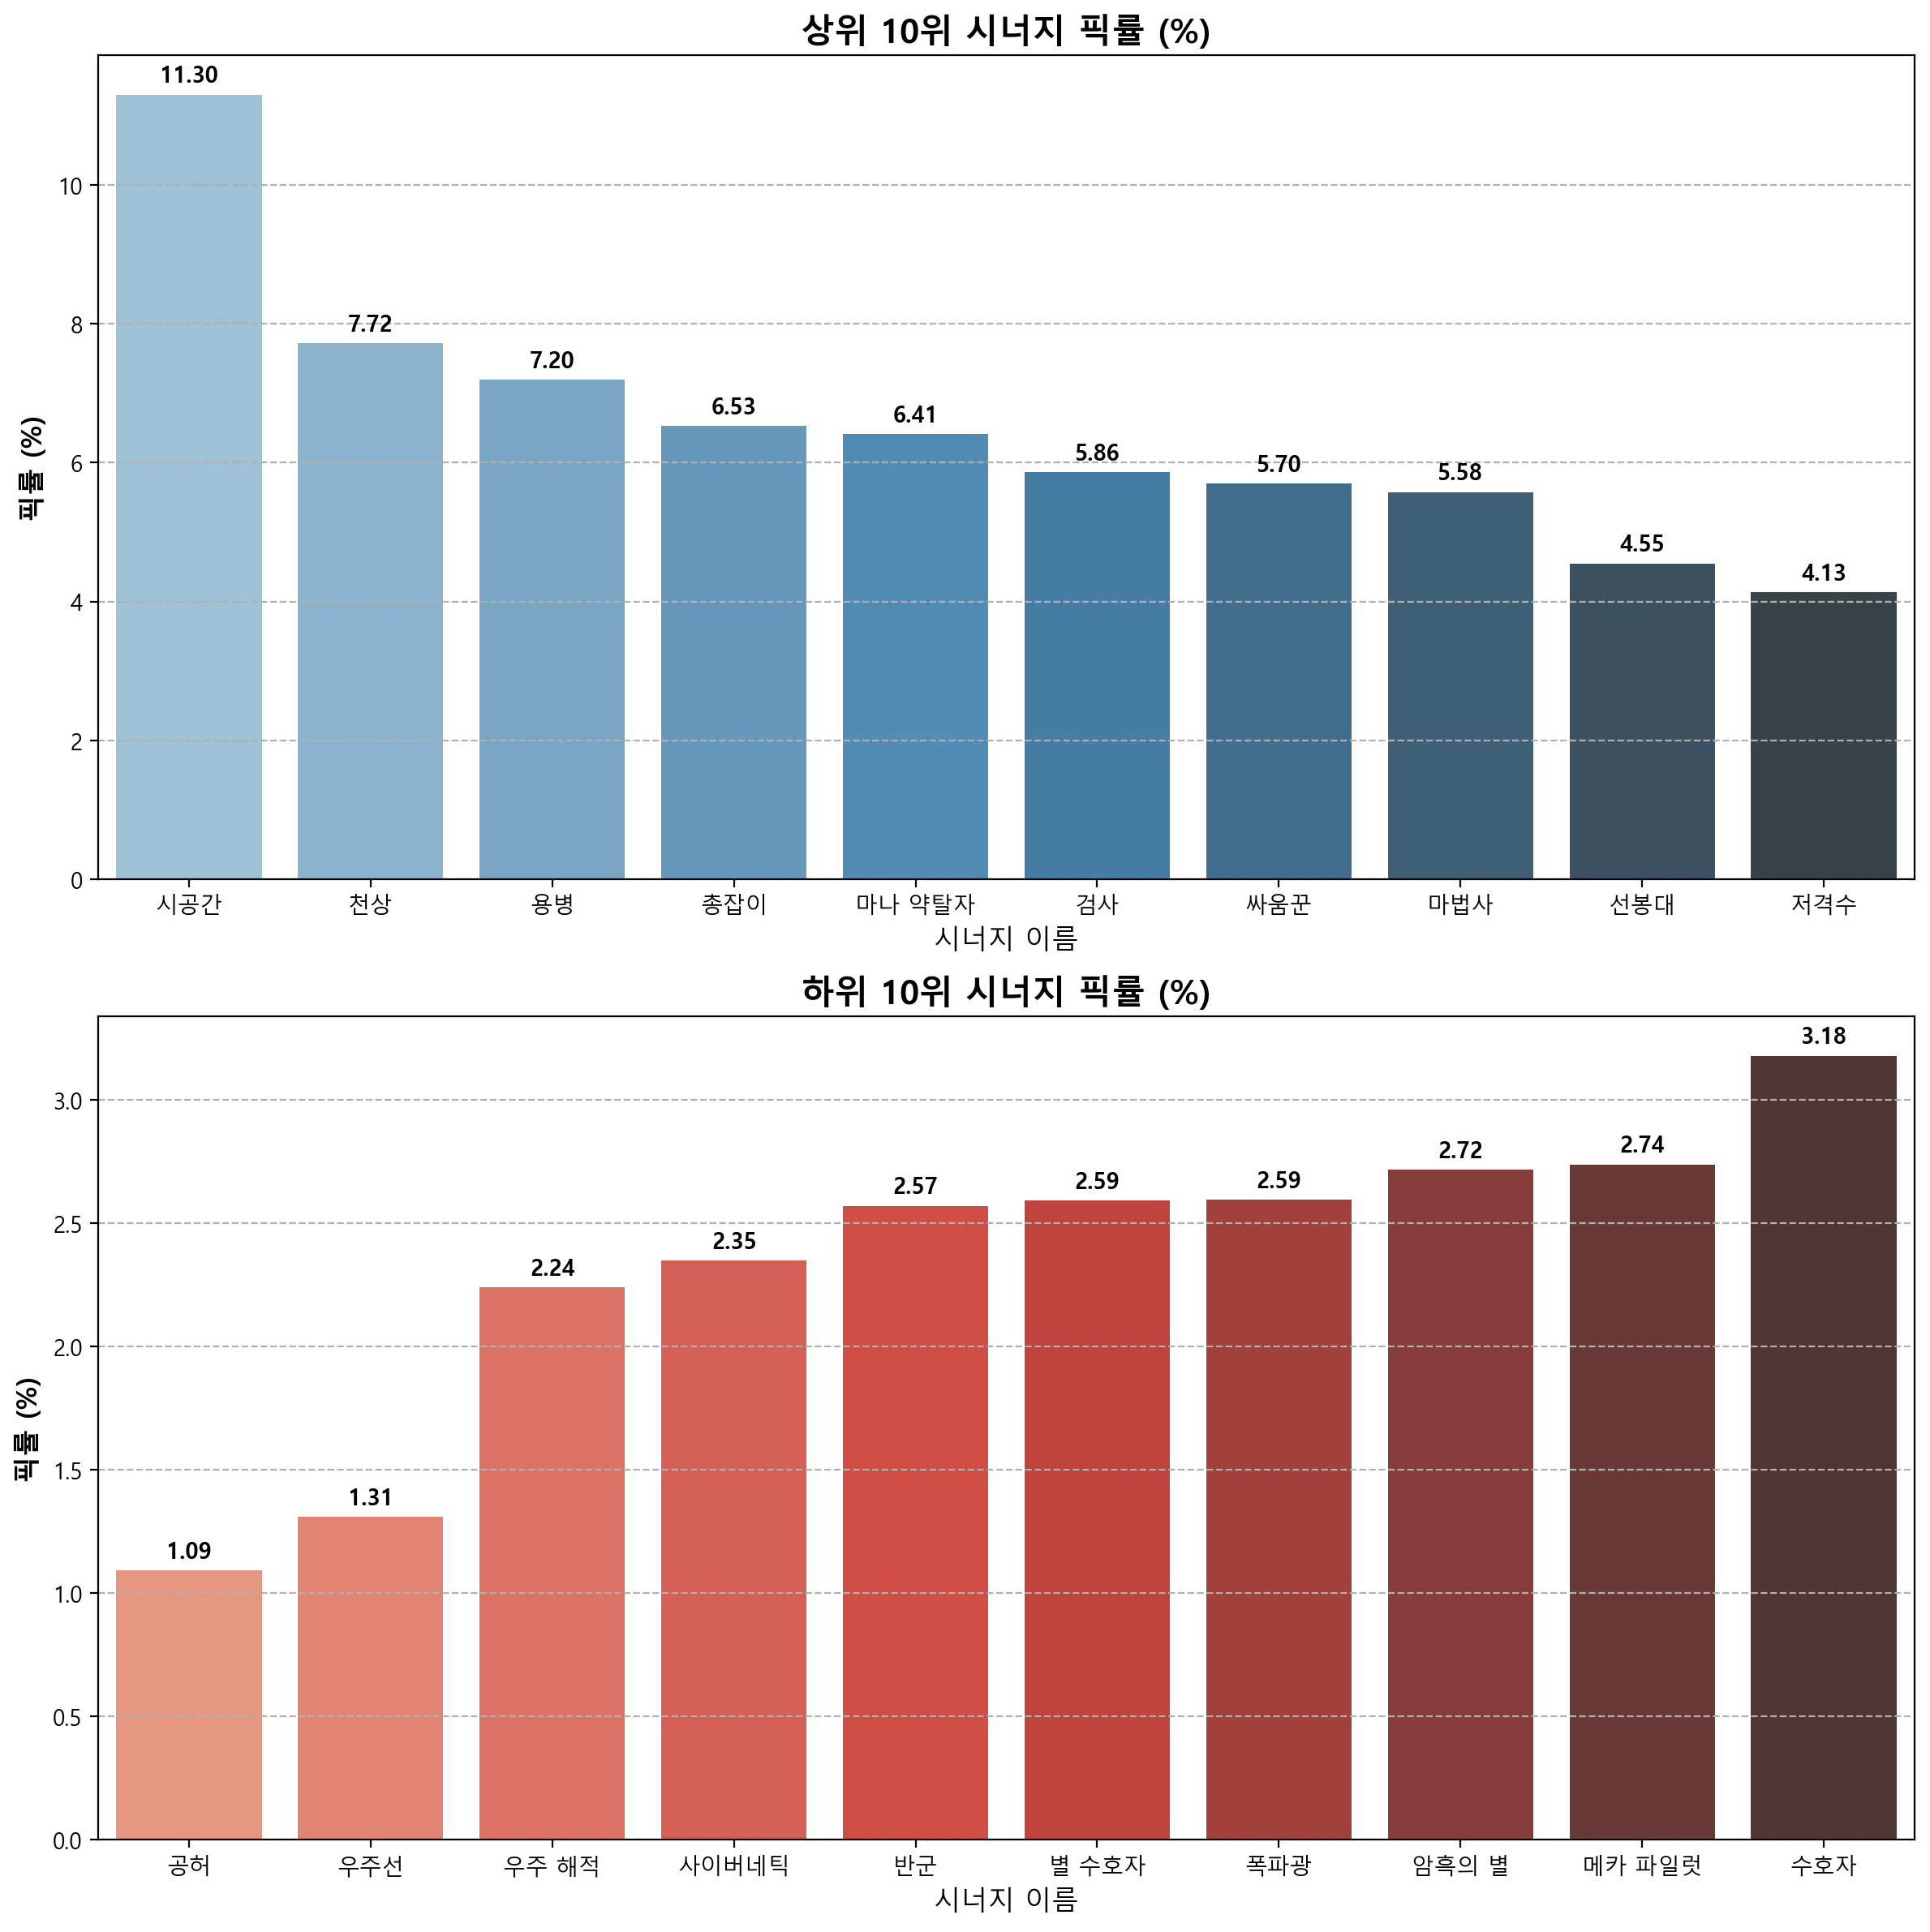

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# (요청사항) 위에 그래프 합치기

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

ax1 = axes[0]
top_comb_pickrate = sns.barplot(
    x='CombinationName', 
    y='PickRate', 
    data=top_10_comb.reset_index(), 
    palette='Blues_d',
    ax=ax1 
)
ax1.set_title('상위 10위 시너지 픽률 (%)', fontsize=15, fontweight='bold')
ax1.set_xlabel('시너지 이름', fontsize=12)
ax1.set_ylabel('픽률 (%)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=0) 
ax1.grid(axis='y', linestyle='--')

for container in top_comb_pickrate.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

ax2 = axes[1]
bottom_comb_pickrate = sns.barplot(
    x='CombinationName', 
    y='PickRate', 
    data=bottom_10_comb.reset_index(), 
    palette='Reds_d',
    ax=ax2 
)
ax2.set_title('하위 10위 시너지 픽률 (%)', fontsize=15, fontweight='bold')
ax2.set_xlabel('시너지 이름', fontsize=12)
ax2.set_ylabel('픽률 (%)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=0) 
ax2.grid(axis='y', linestyle='--')

for container in bottom_comb_pickrate.containers:
    ax2.bar_label(container, fmt='%.2f', padding=3, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout() 
plt.show()

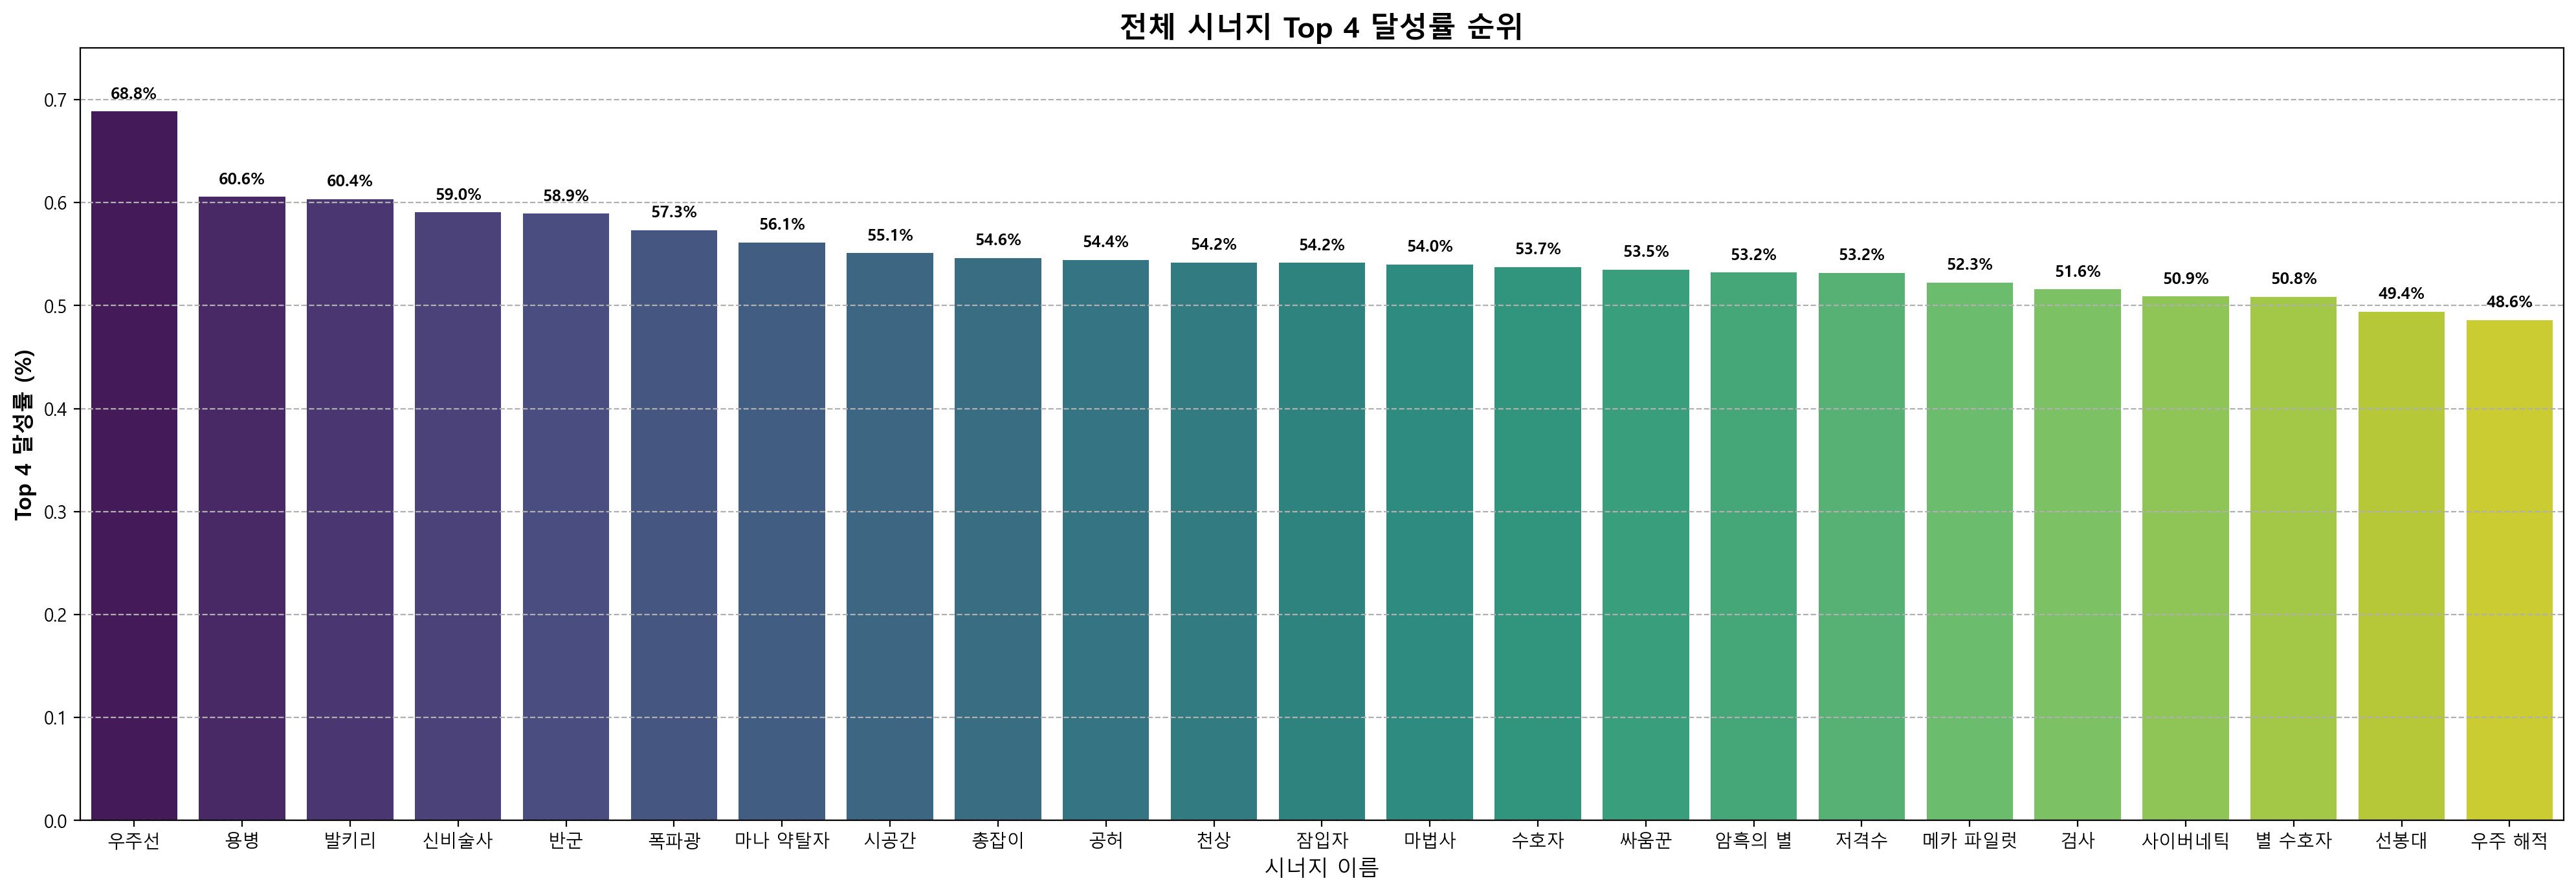

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비 (모든 시너지의 Top 4 달성률 계산)
# Top 4 달성률 계산 (CombinationName 기준으로 집계)
synergy_top4_rate = df_tier_comb.groupby('CombinationName').agg(
    TotalUsage=('CombinationName', 'count'), # 총 활성화 횟수 (선택적으로 포함)
    Top4Rate=('is_top4', 'mean')            # Top 4 달성률
).reset_index()

# Top 4 달성률 기준으로 내림차순 정렬
synergy_top4_rate = synergy_top4_rate.sort_values(by='Top4Rate', ascending=False)

# 막대그래프 생성

plt.figure(figsize=(20, 7)) # 넓이를 넓게 설정하여 23개 시너지 이름을 담습니다.

top4_rate_plot = sns.barplot(
    x='CombinationName', 
    y='Top4Rate', 
    data=synergy_top4_rate, 
    palette='viridis' # GPT 추천 색상 팔레트 사용 (이후 수정 예정)
)

# 그래프 설정

plt.title('전체 시너지 Top 4 달성률 순위', fontsize=16, fontweight='bold')
plt.xlabel('시너지 이름', fontsize=12)
plt.ylabel('Top 4 달성률 (%)', fontsize=12, fontweight='bold')

plt.ylim(0, 0.75)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--')

# 값 표시 (퍼센트 형식)
for container in top4_rate_plot.containers:
    labels = [f'{v.get_height()*100:.1f}%' for v in container] 
    top4_rate_plot.bar_label(container, labels=labels, padding=5, fontsize=9, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()

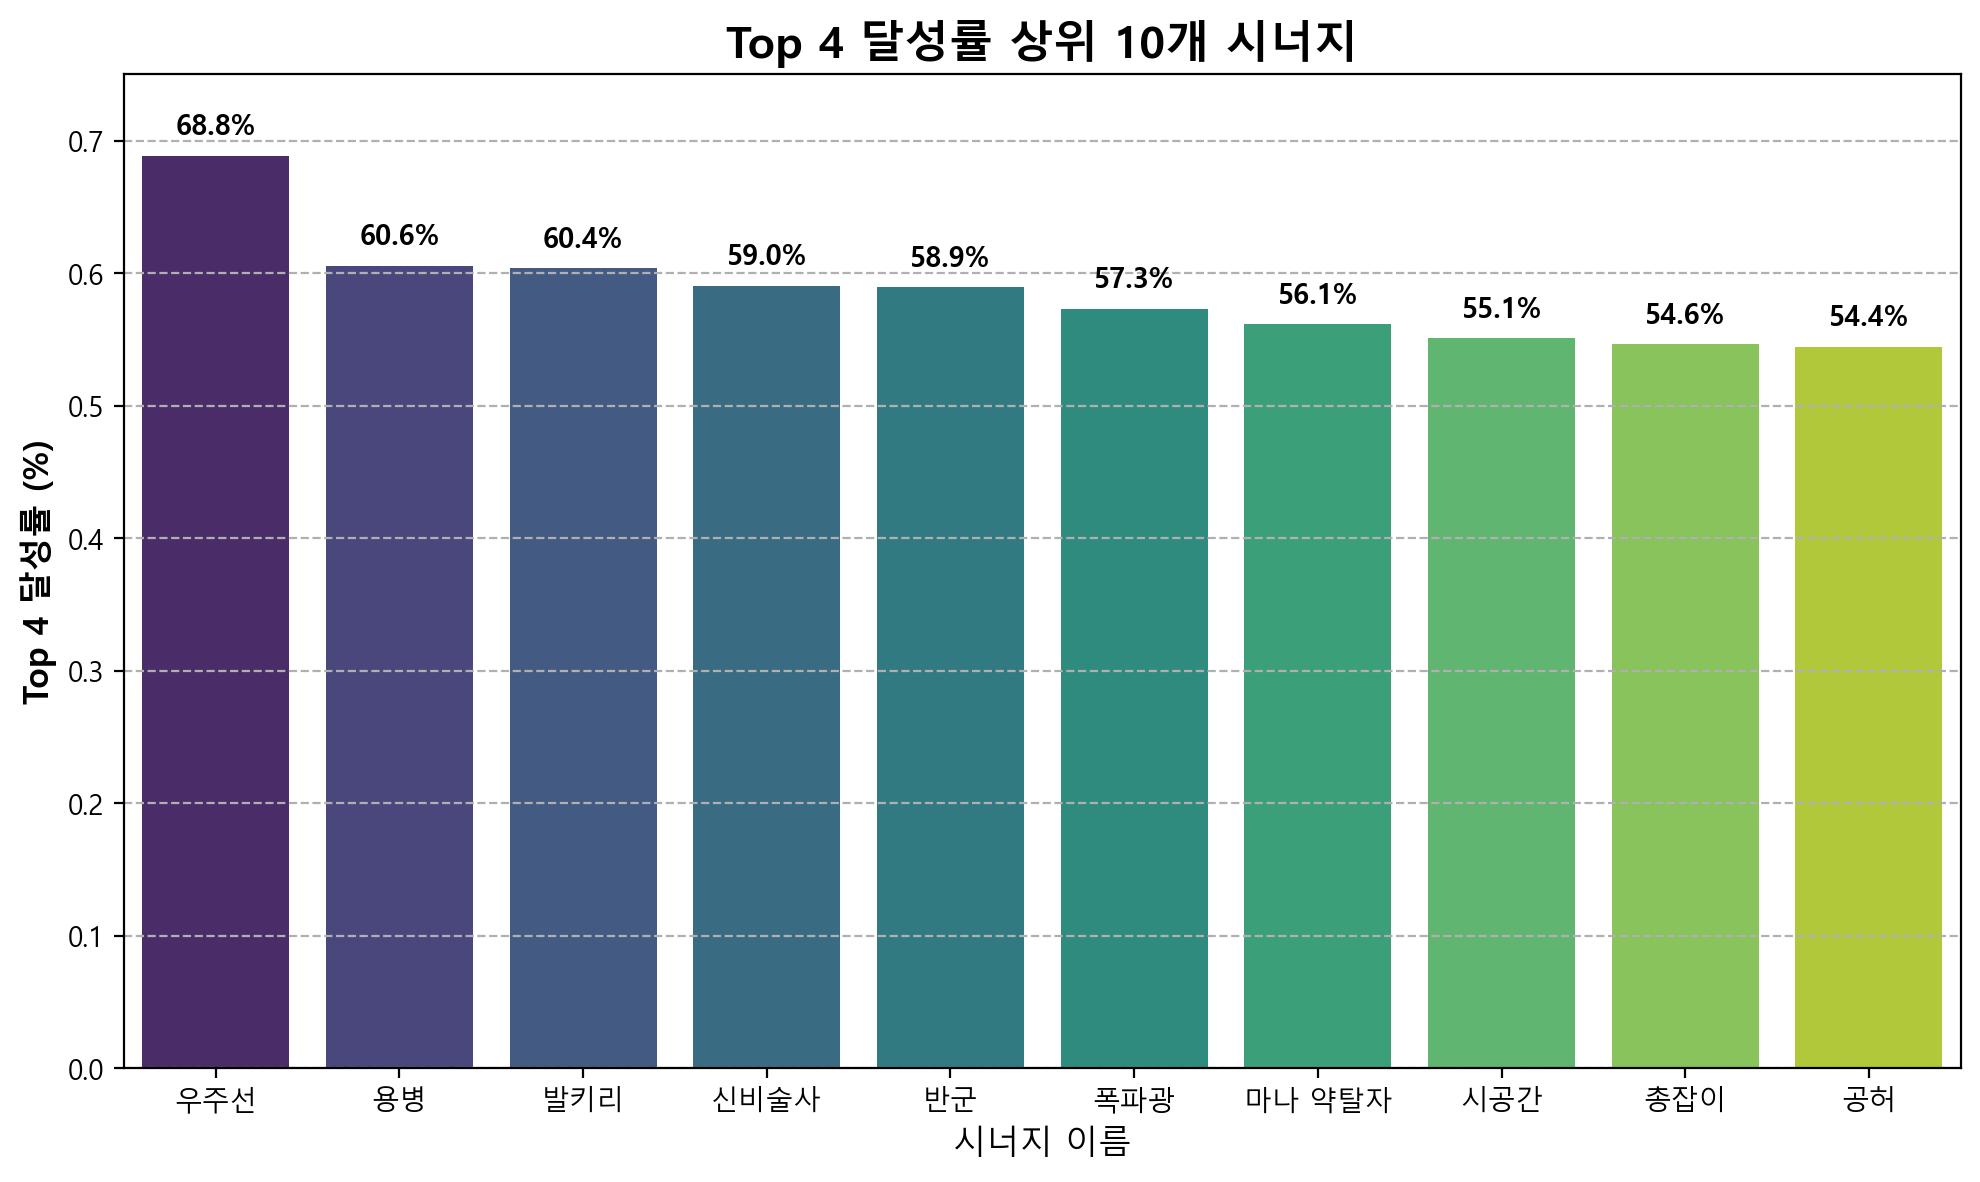

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비 (상위 10개 시너지 추출)
# 모든 시너지의 Top 4 달성률 계산
synergy_top4_rate = df_tier_comb.groupby('CombinationName').agg(
    TotalUsage=('CombinationName', 'count'), # 총 활성화 횟수
    Top4Rate=('is_top4', 'mean')            # Top 4 달성률
).reset_index()

# Top 4 달성률 기준으로 내림차순 정렬 후, 상위 10개만 추출
synergy_top4_rate = synergy_top4_rate.sort_values(by='Top4Rate', ascending=False)
top_10_synergies = synergy_top4_rate.head(10)


# 막대그래프 생성

plt.figure(figsize=(10, 6)) # 그래프 크기 조정

top4_rate_plot = sns.barplot(
    x='CombinationName', 
    y='Top4Rate', 
    data=top_10_synergies, 
    palette='viridis' 
)

# 그래프 설정

plt.title('Top 4 달성률 상위 10개 시너지', fontsize=16, fontweight='bold')
plt.xlabel('시너지 이름', fontsize=12)
plt.ylabel('Top 4 달성률 (%)', fontsize=12, fontweight='bold')

plt.ylim(0, 0.75)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--')

# 값 표시 (퍼센트 형식)
for container in top4_rate_plot.containers:
    labels = [f'{v.get_height()*100:.1f}%' for v in container] 
    top4_rate_plot.bar_label(container, labels=labels, padding=5, fontsize=10, color='black', fontweight='bold') 

plt.tight_layout()
plt.show()

In [121]:
# 시너지별 Top 4 확률 계산
# 'is_top4'의 평균을 구하면 Top 4 진입 확률이 됨
top4_rate_df = df_tier_comb.groupby('CombinationName')['is_top4'].mean().rename('Top4Rate')

# 2. combination_stats 데이터프레임에 Top4Rate 컬럼 추가
# combination_stats의 인덱스가 CombinationName과 일치해야 함
combination_stats = combination_stats.merge(
    top4_rate_df, 
    left_index=True, 
    right_index=True, 
    how='left'
)

# combination_stats에 'Top4Rate' 컬럼 추가

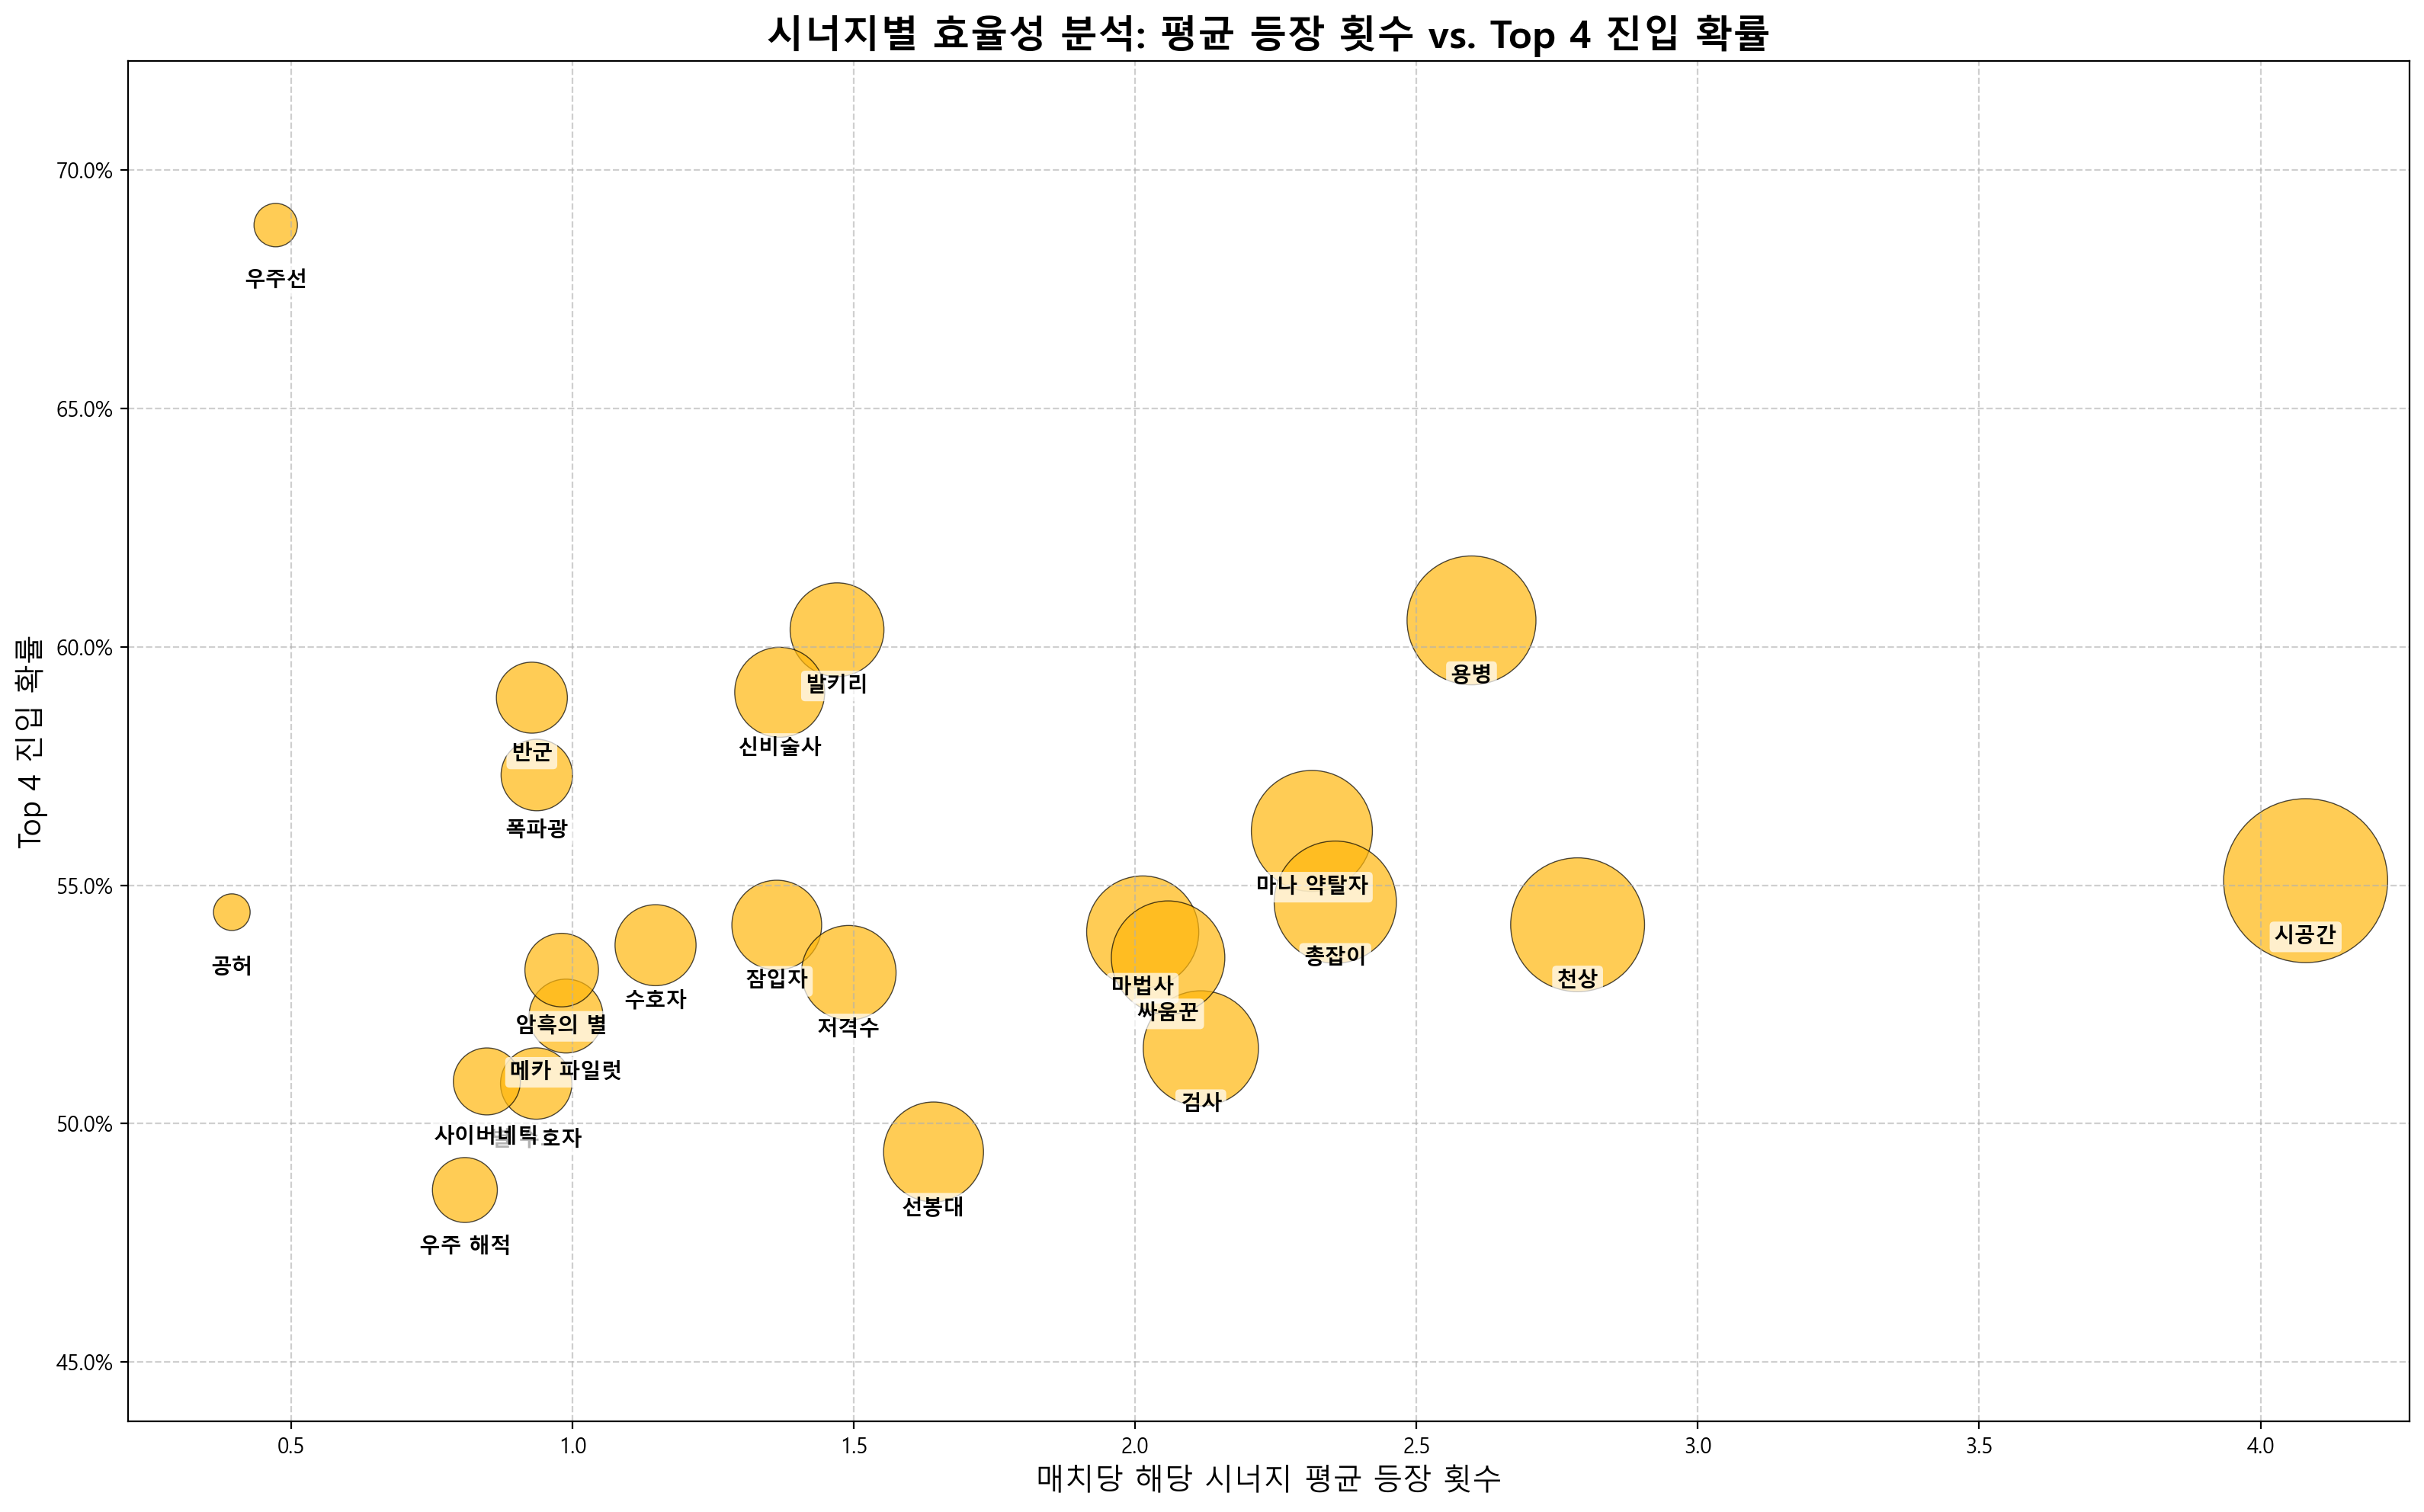

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 매핑을 다시 안하면 영어로 나오는 현상 발생
# 한글 이름 매핑 (유지)
combination_map = {
    "Void": "공허", "MechPilot": "메카 파일럿", "Rebel": "반군", "Valkyrie": "발키리",
    "StarGuardian": "별 수호자", "Cybernetic": "사이버네틱", "Chrono": "시공간",
    "DarkStar": "암흑의 별", "SpacePirate": "우주 해적", "Celestial": "천상",
    "Blademaster": "검사", "ManaReaver": "마나 약탈자", "Sorcerer": "마법사",
    "Vanguard": "선봉대", "Protector": "수호자", "Mystic": "신비술사",
    "Brawler": "싸움꾼", "Mercenary": "용병", "Starship": "우주선",
    "Infiltrator": "잠입자", "Sniper": "저격수", "Blaster": "총잡이",
    "Demolitionist": "폭파광",
}


plt.figure(figsize=(16, 10)) 

# 스캐터 플롯 생성 (X축: AvgActivationsPerGame, Y축: Top4Rate)
ax = sns.scatterplot(
    x='AvgActivationsPerGame', # X축: 매치당 평균 등장 횟수 
    y='Top4Rate',              # Y축: Top 4 진입 확률
    data=combination_stats,   
    size='PickCount',          # 원 크기는 총 활성화 횟수(인기도)
    sizes=(300, 6000),    
    color='#ffb70d',      
    alpha=0.7,            
    edgecolor='black',    
    linewidth=0.5,
    legend=False
)

plt.ylim(combination_stats['Top4Rate'].min() * 0.9, combination_stats['Top4Rate'].max() * 1.05) # 데이터에 맞게 범위 자동 조정


# 2. 한글 시너지 이름 텍스트 추가 (원 밑에 배치)
for index, row in combination_stats.iterrows():
    
    x_val = row['AvgActivationsPerGame'] 
    y_val = row['Top4Rate'] 
    english_name = row.name
    
    korean_name = combination_map.get(english_name, english_name) 
    
    # 텍스트 주석 배치 (원 밑에 배치: y_val에서 오프셋을 뺌)
    plt.text(x_val, 
             y_val - 0.013,
             korean_name,  
             horizontalalignment='center',
             size='medium', 
             color='black', 
             weight='semibold', 
             bbox=dict(boxstyle="round,pad=0.2", fc='white', alpha=0.7, ec='none')) 

# 그래프 설정

plt.title('시너지별 효율성 분석: 평균 등장 횟수 vs. Top 4 진입 확률', fontsize=18, fontweight='bold')
plt.xlabel('매치당 해당 시너지 평균 등장 횟수', fontsize=14)
plt.ylabel('Top 4 진입 확률', fontsize=14)

# Y축 레이블을 백분율로 포맷
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))


plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()